# Cell 0: Notebook Header & Documentation
# Description: Provides context and instructions for this specific notebook.

## Notebook Title: Ablation Study - Harmonic + 4D Biological State (on AIFM1)

### Purpose and Context

*   **Goal:** To test a specific biologically-inspired 4-Dimensional state and ruleset, featuring the Harmonic term and explicit dynamics for Cargo binding/release and Location transitions, on the AIFM1 subgraph. This serves as a key data point in the ablation study, comparing the emergent dynamics to the generic placeholder dimensions and component ablations.
*   **Contribution:** Executes the simulation with the 4D Biological state `[Act, Inh, Cargo, Location]` and its specific ruleset (Harmonic active, Pheromone disabled). Analyzes its dynamics and saves results. This run's output is a crucial element in the subsequent cross-run dynamic analysis (`ablation_09`).
*   **Inputs:**
    *   Requires the baseline configuration file (`baseline_config.json`) saved by `ablation_00`.
    *   Requires the graph data files (`graph_G.pkl`, `graph_pos.pkl`, `node_list.pkl`, etc.) saved by `ablation_00`.
    *   Requires the seed index file (`initial_seed_nodes_idx.pkl`) saved by `ablation_00`.
*   **Outputs:**
    *   A simulation results folder (`simulation_results/string_ca_subgraph_AIFM1_CORRECTED_Harmonic4DBio`).
    *   Analysis plots (Timeseries (Act/Inh/Cargo/Loc), Snapshots, Metrics) for this specific 4D Bio run within its output folder.
    *   Saved history files (`activation_history.csv`, `inhibition_history.csv`, `cargo_history.csv`, `location_history.csv`).
    *   Saved final pheromone state (`final_pheromones.pkl`, expected near zero).
    *   Saved experiment summary (`experiment_summary.json`).
    *   **NOTE:** This notebook DOES NOT generate the `aifm1_red_ids.txt` file.

### How to Run

*   **Prerequisites:** Ensure `ablation_00_Setup_and_Definitions.ipynb` has been run successfully and its output files are present. **Before running Cell 2**, you MUST manually insert **Cell 1.1** containing the full set of necessary Canonical Function Definitions (including `initialize_states_vector`, `hdc_4d_step_vectorized`, `run_simulation_network_automaton`, `run_experiment_no_analysis`, `reformat_history_for_analysis`, `plot_vector_node_history`, `visualize_snapshot`, `calculate_entropy_timeseries`, `detect_oscillations_fft`, and `calculate_clustering_metric`), copied from the version you are managing.
*   **Configuration:** No user edits are required; Cell 1 loads the baseline config and sets the specific 4D Biological configuration internally.
*   **Execution:** Run cells **0 and 1** in order. **Insert the Canonical Function Definitions as Cell 1.1.** Then, run cells **2 and 3** sequentially.
*   **Expected Runtime:** ~10-20 minutes, depending on simulation steps.

### Expected Results & Analysis (within this notebook)

*   This notebook executes the 4D Biological simulation for 1000 steps on the AIFM1 subgraph.
*   It performs analysis (variance, entropy, clustering (4D), FFT) using functions defined in Cell 1.1, adapted for the 4D state.
*   It generates standard plots (timeseries for all 4 dimensions, snapshots, metrics vs. time) saved to this run's output folder.
*   Observe the simulation's termination reason and the final metrics (e.g., variance, entropy, `AvgChange`) to characterize the emergent dynamics of this biologically inspired model on AIFM1. These results will be incorporated into the cross-run dynamic analysis in `ablation_09`.

In [1]:
# Cell 1: Load Configuration and Set 4D Biological Run Parameters (on AIFM1)
# Description: Loads the baseline configuration and graph data files saved by ablation_00.
#              Extracts necessary base parameters. Defines the specific configuration
#              for THIS 4D Biological run (on AIFM1). Seeds the notebook.
#              Defines 4D biological state indices and location constants, setting them as GLOBALS.
#              MODIFIED: Consolidated constant definitions and global assignments for robustness.

import numpy as np
import os
import json
import time
import traceback
import copy
import random
import warnings
import pickle # For loading config/graph objects

print(f"\n--- Cell 1: Load Configuration and Set 4D Biological Run Parameters (on AIFM1) ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# --- Load Baseline Configuration & Seed Indices ---
config_load_error = False
baseline_config = {}
initial_seed_indices_loaded = None
setup_output_dir_load = os.path.join("simulation_results", "Ablation_Setup_Files")

try:
    config_path_load = os.path.join(setup_output_dir_load, "baseline_config.json")
    seed_idx_path_load = os.path.join(setup_output_dir_load, "initial_seed_nodes_idx.pkl")

    if not os.path.exists(config_path_load): raise FileNotFoundError(f"Baseline config file not found: {config_path_load}. Run ablation_00.")
    with open(config_path_load, 'r') as f: baseline_config = json.load(f)
    print(f"  ✅ Loaded baseline configuration from: {config_path_load}")

    if not os.path.exists(seed_idx_path_load): raise FileNotFoundError(f"Seed index file not found: {seed_idx_path_load}. Run ablation_00.")
    with open(seed_idx_path_load, 'rb') as f: initial_seed_indices_loaded = pickle.load(f)
    if not isinstance(initial_seed_indices_loaded, list): raise TypeError("Loaded seed indices are not a list.")
    print(f"  ✅ Successfully loaded seed indices: {initial_seed_indices_loaded} from {seed_idx_path_load}")

    # Extract needed base parameters into local variables for this notebook
    OUTPUT_DIR = baseline_config.get('OUTPUT_DIR', "simulation_results")
    ANALYSIS_DIR = baseline_config.get('ANALYSIS_DIR', "biological_analysis_results") # Keep analysis dir separate

    # --- Extract TARGET_NODE_ID and TARGET_NODE_NAME and set as GLOBALS ---
    TARGET_NODE_ID = baseline_config.get('TARGET_NODE_ID') # AIFM1 ID from setup
    TARGET_NODE_NAME = baseline_config.get('TARGET_NODE_NAME', 'TargetProtein') # Get name if exists, default if not
    globals()['TARGET_NODE_ID'] = TARGET_NODE_ID # Set as global
    globals()['TARGET_NODE_NAME'] = TARGET_NODE_NAME # Set as global
    print(f"  Target Node ID loaded and set globally: {TARGET_NODE_ID} ({TARGET_NODE_NAME})")
    # --- END Extract and Set GLOBALS ---


    NODES_TO_PLOT_COUNT = baseline_config.get('NODES_TO_PLOT_COUNT', 10)
    MASTER_SEED = baseline_config.get('MASTER_SEED', 42)
    # Seed numpy and python random for this notebook
    # Use MASTER_SEED + 7 for the 4D Biological run
    BIO_4D_RUN_SEED = MASTER_SEED + 7
    np.random.seed(BIO_4D_RUN_SEED)
    random.seed(BIO_4D_RUN_SEED)
    print(f"  Seeding notebook with run-specific seed: {BIO_4D_RUN_SEED}")


    if None in [OUTPUT_DIR, ANALYSIS_DIR, TARGET_NODE_ID]: raise ValueError("Essential base parameters missing from loaded config.")

except FileNotFoundError as e: print(f"❌ ERROR: {e}"); config_load_error = True
except Exception as e: print(f"❌ Error loading config/seed data: {e}")
except TypeError as e: print(f"❌ Type Error loading data: {e}")
except ValueError as e: print(f"❌ Value Error in config: {e}")
except Exception as e: print(f"❌ An unexpected error occurred: {e}")
finally:
     if config_load_error:
          traceback.print_exc(limit=2) # Print traceback only if error occurred


if not config_load_error:
    # --- Define 4D Biological State Indices and Location Constants AND SET AS GLOBALS ---
    # S = [u, v, cargo, location]
    ACT_IDX = 0     # Activation (u)
    INH_IDX = 1     # Inhibition (v)
    CARGO_IDX = 2   # Cargo Binding Status (0: unbound, 1: bound)
    LOC_IDX = 3     # Subcellular Location Index (Discrete Integer)
    BIO_4D_STATE_DIM = 4   # Explicitly 4D Biological

    # Define Location Constants (consistent with Biological model in NISC)
    LOC_GOLGI = 0
    LOC_EE = 1      # Early Endosome
    LOC_LE = 2      # Late Endosome
    LOC_PM = 3      # Plasma Membrane
    LOC_LY = 4      # Lysosome (Terminal state)
    NUM_LOCATIONS = 5 # Total number of distinct locations defined

    # --- Set these indices and constants as GLOBALS ---
    # CONSOLIDATED GLOBAL ASSIGNMENTS
    globals()['ACT_IDX'] = ACT_IDX
    globals()['INH_IDX'] = INH_IDX
    globals()['CARGO_IDX'] = CARGO_IDX
    globals()['LOC_IDX'] = LOC_IDX
    globals()['STATE_DIM'] = BIO_4D_STATE_DIM # Use BIO_4D_STATE_DIM to set global STATE_DIM
    globals()['LOC_GOLGI'] = LOC_GOLGI
    globals()['LOC_EE'] = LOC_EE
    globals()['LOC_LE'] = LOC_LE
    globals()['LOC_PM'] = LOC_PM
    globals()['LOC_LY'] = LOC_LY
    globals()['NUM_LOCATIONS'] = NUM_LOCATIONS
    # --- END Set GLOBALS ---

    print(f"\n  Set Global State Indices: Act={ACT_IDX}, Inh={INH_IDX}, Cargo={CARGO_IDX}, Loc={LOC_IDX}, Dim={STATE_DIM}")
    print(f"  Set Global Location Constants: Golgi={LOC_GOLGI}, EE={LOC_EE}, LE={LOC_LE}, PM={LOC_PM}, LY={LOC_LY}, Num={NUM_LOCATIONS}")


    BIO_4D_EXPERIMENT_BASE_NAME = baseline_config.get('EXPERIMENT_NAME','string_ca_subgraph_AIFM1_CORRECTED')
    # Use _Harmonic4DBio suffix for this run on AIFM1
    BIO_4D_EXPERIMENT_NAME = f"{BIO_4D_EXPERIMENT_BASE_NAME}_Harmonic4DBio"
    print(f"\nConfiguring 4D Biological Run on AIFM1: {BIO_4D_EXPERIMENT_NAME}")

    # --- State Parameters (4D Biological) ---
    # Seed: Activated (u=1), Unbound (cargo=0), in Golgi (loc=0), Inh=0
    BIO_4D_SEED_ACTIVATION_VALUE = np.array([1.0, 0.0, 0.0, float(LOC_GOLGI)], dtype=float)
    # Default: Inactive (u=0, v=0), Unbound (cargo=0), in Golgi (loc=0)
    BIO_4D_DEFAULT_INACTIVE_STATE = np.array([0.0, 0.0, 0.0, float(LOC_GOLGI)], dtype=float)
    print(f"  Seed Value: {BIO_4D_SEED_ACTIVATION_VALUE}")
    print(f"  Default State: {BIO_4D_DEFAULT_INACTIVE_STATE}")


    # --- Rule Parameters (Harmonic + 4D Biological Rules) ---
    # These parameters are adapted from the NISC notebook's Cell 1, 4D Bio ruleset
    bio_4d_rule_params = copy.deepcopy(baseline_config.get('rule_params', {}))

    # Core Act/Inh (keep baseline values)
    bio_4d_rule_params['activation_threshold'] = 0.5
    bio_4d_rule_params['activation_increase_rate'] = 0.15
    bio_4d_rule_params['activation_decay_rate'] = 0.05
    bio_4d_rule_params['inhibition_threshold'] = 0.5 # Keep this separate, NISC used neighbor Act for both thresholds
    bio_4d_rule_params['inhibition_increase_rate'] = 0.1 # Keep this
    bio_4d_rule_params['inhibition_decay_rate'] = 0.1
    bio_4d_rule_params['inhibition_feedback_threshold'] = 0.6 # u>thresh increases v
    bio_4d_rule_params['inhibition_feedback_strength'] = 0.3

    # Harmonic (Active in this run)
    bio_4d_rule_params['harmonic_factor'] = 0.05             # <<< HARMONIC ACTIVE >>>

    # Pheromone (Disabled in this run)
    bio_4d_rule_params['pheromone_increase_rate'] = 0.0     # <<< PHEROMONE DISABLED >>>
    bio_4d_rule_params['pheromone_multiplicative_decay_rate'] = 0.99 # Value doesn't matter

    # Cargo Binding/Release (Specific 4D Bio Rules) - From NISC Cell 1
    bio_4d_rule_params['cargo_binding_rate_golgi'] = 0.1
    bio_4d_rule_params['cargo_release_prob_le'] = 0.9

    # Location Transitions (Specific 4D Bio Rules) - From NISC Cell 1
    bio_4d_rule_params['loc_golgi_ee_prob'] = 0.05
    bio_4d_rule_params['loc_ee_le_prob'] = 0.1
    bio_4d_rule_params['loc_le_ly_prob'] = 0.02
    bio_4d_rule_params['loc_le_golgi_prob'] = 0.08
    bio_4d_rule_params['random_walk_prob'] = 0.001 # Small random walk

    # Coupling between state dimensions (Specific 4D Bio Rules) - From NISC Cell 1
    bio_4d_rule_params['cargo_boosts_activation_factor'] = 0.1
    bio_4d_rule_params['le_increases_inhibition_factor'] = 0.2

    # Diffusion and Noise (Only on Act/Inh in 4D Bio - matches decoupled placeholder)
    bio_4d_rule_params['diffusion_factor'] = 0.05 # Diffusion factor value
    bio_4d_rule_params['noise_level'] = 0.001     # Noise level value
    # Note: The 4D Bio step function explicitly applies diffusion/noise only to Act/Inh

    # Ensure generic placeholder decays are off
    bio_4d_rule_params['placeholder_decay_rate'] = 0.0;
    bio_4d_rule_params['w_decay_rate'] = 0.0; bio_4d_rule_params['x_decay_rate'] = 0.0; bio_4d_rule_params['y_decay_rate'] = 0.0;

    # Ensure Dynamic Weights are off
    bio_4d_rule_params['use_dynamic_weights'] = False; bio_4d_rule_params['additional_decay_factor'] = 0.0;

    # Weight usage flag
    bio_4d_rule_params['use_confidence_weight'] = True;

    print("  Rule Parameters (Harmonic + 4D Biological):"); print(json.dumps(bio_4d_rule_params, indent=2))


    # --- Simulation Parameters ---
    BIO_4D_MAX_SIMULATION_STEPS = 500 # Set to 100 steps
    BIO_4D_CONVERGENCE_THRESHOLD = baseline_config.get('CONVERGENCE_THRESHOLD', 0.0001)
    # Adjusted snapshot steps for longer simulation
    num_snaps = 5
    BIO_4D_SNAPSHOT_STEPS = [int(i * (BIO_4D_MAX_SIMULATION_STEPS - 1) / (num_snaps - 1)) for i in range(num_snaps)] if num_snaps > 1 and BIO_4D_MAX_SIMULATION_STEPS > 0 else [BIO_4D_MAX_SIMULATION_STEPS - 1 if BIO_4D_MAX_SIMULATION_STEPS > 0 else 0]
    if BIO_4D_MAX_SIMULATION_STEPS > 0 and 0 not in BIO_4D_SNAPSHOT_STEPS: BIO_4D_SNAPSHOT_STEPS.insert(0, 0) # Ensure step 0 included if steps > 0
    BIO_4D_SNAPSHOT_STEPS = sorted(list(set(BIO_4D_SNAPSHOT_STEPS)))
    # Ensure last step is included if simulation steps > 0
    if BIO_4D_MAX_SIMULATION_STEPS > 0 and (BIO_4D_MAX_SIMULATION_STEPS - 1) not in BIO_4D_SNAPSHOT_STEPS:
         BIO_4D_SNAPSHOT_STEPS.append(BIO_4D_MAX_SIMULATION_STEPS - 1)
         BIO_4D_SNAPSHOT_STEPS = sorted(list(set(BIO_4D_SNAPSHOT_STEPS)))

    print(f"  Max Steps: {BIO_4D_MAX_SIMULATION_STEPS}")
    print(f"  Snapshot Steps: {BIO_4D_SNAPSHOT_STEPS}")

    # --- MODIFIED: Add print statement to verify STATE_DIM before use ---
    print(f"  Verifying STATE_DIM value before config dict creation: {STATE_DIM}")
    # --- END MODIFIED ---

    # --- Prepare Config Dictionary for run_experiment ---
    # MODIFIED: Create config_for_4d_bio_run using the local variables defined above.
    config_for_4d_bio_run = {
        'EXPERIMENT_NAME': BIO_4D_EXPERIMENT_NAME,
        'STATE_DIM': BIO_4D_STATE_DIM, # Use the variable
        'SEED_ACTIVATION_VALUE': BIO_4D_SEED_ACTIVATION_VALUE.tolist(), # Use the variable
        'DEFAULT_INACTIVE_STATE': BIO_4D_DEFAULT_INACTIVE_STATE.tolist(), # Use the variable
        'INIT_MODE': baseline_config.get('INIT_MODE', 'seeds'),
        'INITIAL_SEED_NODES_IDX': initial_seed_indices_loaded, # Use loaded list
        'rule_params': bio_4d_rule_params, # Use the variable
        'MAX_SIMULATION_STEPS': BIO_4D_MAX_SIMULATION_STEPS, # Use the variable
        'CONVERGENCE_THRESHOLD': BIO_4D_CONVERGENCE_THRESHOLD, # Use the variable
        'OUTPUT_DIR': OUTPUT_DIR, # Use the variable
        'NODES_TO_PLOT_COUNT': NODES_TO_PLOT_COUNT, # Use the variable
        'SNAPSHOT_STEPS': BIO_4D_SNAPSHOT_STEPS, # Use the variable
        # Include location constants in config for access by visualizer/analysis if needed
        'LOC_GOLGI': LOC_GOLGI, 'LOC_EE': LOC_EE, 'LOC_LE': LOC_LE, 'LOC_PM': LOC_PM, 'LOC_LY': LOC_LY, 'NUM_LOCATIONS': NUM_LOCATIONS,
        'ACT_IDX': ACT_IDX, 'INH_IDX': INH_IDX, 'CARGO_IDX': CARGO_IDX, 'LOC_IDX': LOC_IDX,
        # Include TARGET_NODE_ID and TARGET_NODE_NAME for visualizer/analysis
        'TARGET_NODE_ID': TARGET_NODE_ID, 'TARGET_NODE_NAME': TARGET_NODE_NAME
    }
else:
    print("\n❌ Cannot proceed without loading baseline configuration.")
    config_for_4d_bio_run = None # Ensure variable is None if config failed


print("\nCell 1: 4D Biological Run Configuration (on AIFM1) set.")


--- Cell 1: Load Configuration and Set 4D Biological Run Parameters (on AIFM1) (2025-04-28 21:08:55) ---
  ✅ Loaded baseline configuration from: simulation_results/Ablation_Setup_Files/baseline_config.json
  ✅ Successfully loaded seed indices: [556] from simulation_results/Ablation_Setup_Files/initial_seed_nodes_idx.pkl
  Target Node ID loaded and set globally: 9606.ENSP00000287295 (TargetProtein)
  Seeding notebook with run-specific seed: 49

  Set Global State Indices: Act=0, Inh=1, Cargo=2, Loc=3, Dim=4
  Set Global Location Constants: Golgi=0, EE=1, LE=2, PM=3, LY=4, Num=5

Configuring 4D Biological Run on AIFM1: string_ca_subgraph_AIFM1_CORRECTED_Harmonic4DBio
  Seed Value: [1. 0. 0. 0.]
  Default State: [0. 0. 0. 0.]
  Rule Parameters (Harmonic + 4D Biological):
{
  "activation_threshold": 0.5,
  "activation_increase_rate": 0.15,
  "activation_decay_rate": 0.05,
  "inhibition_threshold": 0.5,
  "inhibition_increase_rate": 0.1,
  "inhibition_decay_rate": 0.1,
  "inhibition_feedba

In [2]:
# Cell 1.1: Function Definitions for Ablation 07 (4D Biological)
# Description: Defines the necessary functions for state initialization, the 4D Biological
#              simulation step, its runner, the experiment orchestrator (adapted for 4D Bio),
#              and analysis/visualization helpers required by Cells 2 and 3 of THIS notebook.
#              This cell is NOT intended to be identical across all notebooks and contains
#              ONLY the functions needed *by this specific notebook's execution*.
#              MODIFIED: Corrected `initialize_states_vector` to accept keyword `node_list`
#                        and `run_experiment_no_analysis` to accept `graph_obj` and `config_dict_in`.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import networkx as nx
from scipy.stats import entropy as calculate_shannon_entropy
from numpy.fft import fft, fftfreq
from tqdm.auto import tqdm
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pickle
import json
import copy
import traceback
import time
import random
from IPython.display import display, Image  # Keep for snapshot visualization helper

print("\n--- Cell 1.1: Defining Functions for Ablation 07 (4D Biological) ---")

# === STATE INITIALIZATION FUNCTION ===
def initialize_states_vector(node_list=None, node_list_local=None,
                             init_mode='zeros', seed_indices=None,
                             seed_value=None, default_state=None):
    """
    Initializes states. Handles 'seeds' mode. Accepts either `node_list` or `node_list_local`.
    Infers state dim. Returns a dictionary {node_id: state_array}.
    """
    # allow either keyword
    if node_list is None:
        node_list_use = node_list_local
    else:
        node_list_use = node_list

    if not isinstance(node_list_use, list):
        print("Error: initialize_states_vector requires node_list as a list.")
        return {}
    if not node_list_use:
        print("Warning: initialize_states_vector received empty node list.")
        return {}
    states = {}  # This will be the dictionary returned
    state_dim = -1
    default_state_arr = None
    seed_value_arr = None
    try:
        if default_state is not None:
            default_state_arr = np.array(default_state, dtype=float)
            state_dim = len(default_state_arr)
        elif seed_value is not None:
            temp_seed_arr = np.array(seed_value, dtype=float)
            state_dim = len(temp_seed_arr)
            default_state_arr = np.zeros(state_dim, dtype=temp_seed_arr.dtype)
        else:
            state_dim = 2
            default_state_arr = np.array([0.0, 0.0], dtype=float)
            warnings.warn("Default state/seed missing, assuming 2D float zeros.")
        if seed_value is not None:
            seed_value_arr = np.array(seed_value, dtype=default_state_arr.dtype)
            if seed_value_arr.shape != (state_dim,):
                raise ValueError(f"Seed value dimension ({len(seed_value_arr)}) doesn't match determined state dimension ({state_dim}).")
        else:
            seed_value_arr = default_state_arr.copy()
            if state_dim > 0:
                seed_value_arr[0] = 1.0
    except Exception as e:
        print(f"Error processing state parameters: {e}")
        return {}

    print(f"Initializing {state_dim}D states for {len(node_list_use)} nodes (mode: '{init_mode}')...")
    for node_id in node_list_use:
        states[node_id] = default_state_arr.copy()

    if init_mode == 'zeros':
        pass
    elif init_mode == 'random':
        for node_id in node_list_use:
            states[node_id] = np.random.rand(state_dim).astype(default_state_arr.dtype)
    elif init_mode == 'seeds':
        if seed_indices and isinstance(seed_indices, list):
            for idx in seed_indices:
                if 0 <= idx < len(node_list_use):
                    states[node_list_use[idx]] = seed_value_arr.copy()
    else:
        warnings.warn(f"Unknown init_mode '{init_mode}'. Using default.")
    print("  State initialization complete.")
    return states

# === 4D STEP FUNCTION ===
def hdc_4d_step_vectorized(graph, current_states_dict, current_pheromones_dict,
                          node_list_local, node_to_int_local, config):
    """
    Runs one 4D simulation step with biological state [Act, Inh, Cargo, Loc].
    Returns: next_states_dict, next_pheromones_dict, avg_state_change.
    """
    act_idx = config.get('ACT_IDX', 0)
    inh_idx = config.get('INH_IDX', 1)
    cargo_idx = config.get('CARGO_IDX', 2)
    loc_idx = config.get('LOC_IDX', 3)
    state_dim = config.get('STATE_DIM', 4)
    loc_golgi = config.get('LOC_GOLGI', 0)
    loc_ee = config.get('LOC_EE', 1)
    loc_le = config.get('LOC_LE', 2)

    num_nodes = len(node_list_local)
    if num_nodes == 0:
        return current_states_dict, current_pheromones_dict, 0.0

    try:
        # Rule params
        rp = config.get('rule_params', {})
        act_thresh = rp.get('activation_threshold', 0.5)
        act_inc = rp.get('activation_increase_rate', 0.15)
        act_dec = rp.get('activation_decay_rate', 0.05)
        inh_thresh = rp.get('inhibition_threshold', 0.5)
        inh_inc = rp.get('inhibition_increase_rate', 0.1)
        inh_dec = rp.get('inhibition_decay_rate', 0.1)
        cargo_bind = rp.get('cargo_binding_rate_golgi', 0.1)
        cargo_rel = rp.get('cargo_release_prob_le', 0.9)
        loc_g_ee = rp.get('loc_golgi_ee_prob', 0.05)
        loc_ee_le = rp.get('loc_ee_le_prob', 0.1)
        loc_le_ly = rp.get('loc_le_ly_prob', 0.02)
        loc_le_g = rp.get('loc_le_golgi_prob', 0.08)
        rand_walk = rp.get('random_walk_prob', 0.001)
        diff = rp.get('diffusion_factor', 0.05)
        noise = rp.get('noise_level', 0.001)
        cargo_boost = rp.get('cargo_boosts_activation_factor', 0.1)
        inh_boost = rp.get('le_increases_inhibition_factor', 0.2)
        harm = rp.get('harmonic_factor', 0.05)

        # Build arrays
        first = next((v for v in current_states_dict.values() if isinstance(v, np.ndarray)), None)
        dtype = first.dtype
        default = np.array(config.get('DEFAULT_INACTIVE_STATE', np.zeros(state_dim)), dtype=dtype)
        curr = np.array([current_states_dict.get(n, default) for n in node_list_local], dtype=dtype)
        nxt = curr.copy()

        # Precompute neighbors
        deg = np.zeros(num_nodes, int)
        neigh_mean = np.zeros((num_nodes, 2), dtype=dtype)
        act_inf = np.zeros(num_nodes, dtype=dtype)
        for i, n in enumerate(node_list_local):
            nbrs = [u for u in graph.neighbors(n) if u in node_to_int_local]
            deg[i] = len(nbrs)
            if nbrs:
                idxs = [node_to_int_local[u] for u in nbrs]
                st = curr[idxs, :]
                neigh_mean[i] = np.mean(st[:, [act_idx, inh_idx]], axis=0)
                wsum = 0.0
                for j, u in enumerate(nbrs):
                    w = graph.get_edge_data(n, u, {}).get('weight', 1.0)
                    wsum += st[j, act_idx] * w
                act_inf[i] = wsum

        u, v, c, l = curr[:, act_idx], curr[:, inh_idx], curr[:, cargo_idx], curr[:, loc_idx].astype(int)
        delta_u = np.zeros(num_nodes, dtype=dtype)
        delta_v = np.zeros(num_nodes, dtype=dtype)

        # Cargo binding/release
        mask_b = (l == loc_golgi) & (c == 0)
        bind_now = np.random.rand(num_nodes) < cargo_bind
        nxt[:, cargo_idx][bind_now] = 1.0
        mask_r = (l == loc_le) & (c == 1)
        rel_now = np.random.rand(num_nodes) < cargo_rel
        nxt[:, cargo_idx][rel_now] = 0.0

        # Location transitions
        rnd = np.random.rand(num_nodes)
        g2ee = (l == loc_golgi) & (rnd < loc_g_ee)
        nxt[:, loc_idx][g2ee] = loc_ee
        ee2le = (l == loc_ee) & (rnd < loc_ee_le)
        nxt[:, loc_idx][ee2le] = loc_le
        le2ly = (l == loc_le) & (rnd < loc_le_ly)
        nxt[:, loc_idx][le2ly] = config.get('LOC_LY', 4)
        le2g = (l == loc_le) & (~le2ly) & (rnd < loc_le_g)
        nxt[:, loc_idx][le2g] = loc_golgi

        # Activation/Inhibition updates
        inc_mask = act_inf > act_thresh
        delta_u[inc_mask] += act_inc * (1 - u[inc_mask]) * (1 + cargo_boost * (nxt[:, cargo_idx][inc_mask] == 1))
        delta_u -= act_dec * u
        fb_mask = u > rp.get('inhibition_feedback_threshold', 0.6)
        delta_v[fb_mask] += rp.get('inhibition_feedback_strength', 0.3) * (1 - v[fb_mask])
        delta_v -= inh_dec * v

        # Diffusion
        has_n = deg > 0
        diff_chg = diff * (neigh_mean - curr[:, [act_idx, inh_idx]])
        nxt[has_n, act_idx] += diff_chg[has_n, 0]
        nxt[has_n, inh_idx] += diff_chg[has_n, 1]

        # Harmonic term
        if harm:
            tot = np.zeros(num_nodes)
            for i, n in enumerate(node_list_local):
                nbrs = [u for u in graph.neighbors(n) if u in node_to_int_local]
                idxs = [node_to_int_local[u] for u in nbrs]
                tot[i] = np.sum(curr[idxs, act_idx]) if nbrs else 0
            ham = harm * deg * np.sin(tot)
            nxt[:, act_idx] += ham

        # Noise
        noise_arr = np.random.uniform(-noise, noise, size=(num_nodes, 2)).astype(dtype)
        nxt[:, act_idx] += noise_arr[:, 0]
        nxt[:, inh_idx] += noise_arr[:, 1]

        # Clip
        nxt[:, act_idx] = np.clip(nxt[:, act_idx], -1.5, 1.5)
        nxt[:, inh_idx] = np.clip(nxt[:, inh_idx], -1.5, 1.5)
        nxt[:, cargo_idx] = np.round(np.clip(nxt[:, cargo_idx], 0, 1))
        nxt[:, loc_idx] = np.round(np.clip(nxt[:, loc_idx], 0, config.get('NUM_LOCATIONS', 5)-1))

        next_states_dict = {node_list_local[i]: nxt[i] for i in range(num_nodes)}
        avg_change = np.mean(np.abs(nxt[:, [act_idx, inh_idx]] - curr[:, [act_idx, inh_idx]]))
        return next_states_dict, current_pheromones_dict, avg_change

    except Exception as e:
        print(f"Error in hdc_4d_step_vectorized: {e}")
        traceback.print_exc(limit=2)
        return None, None, -1.0

# === SIMULATION RUNNER ===
def run_simulation_network_automaton(
    graph_obj, initial_states_dict, initial_pheromones_dict, config_local,
    max_steps, convergence_thresh, node_list_local):
    """
    Runs the simulation using hdc_4d_step_vectorized.
    Returns: state_history_list, final_pheromones_dict, termination_reason.
    """
    if not initial_states_dict or not isinstance(initial_states_dict, dict):
        return [], {}, "error_initial_states"
    if not node_list_local or not isinstance(node_list_local, list):
        return [], {}, "error_missing_node_list"
    pher = initial_pheromones_dict if isinstance(initial_pheromones_dict, dict) else {}
    node_to_int = config_local.get('node_to_int') or {n: i for i, n in enumerate(node_list_local)}
    step_fn = globals()['hdc_4d_step_vectorized']
    history = [initial_states_dict.copy()]
    reason = "max_steps_reached"
    pbar = tqdm(range(max_steps), desc=f"Sim {config_local.get('EXPERIMENT_NAME','Run')}", unit="step")
    for i in pbar:
        nxt, pher, chg = step_fn(graph_obj, history[-1], pher, node_list_local, node_to_int, config_local)
        if nxt is None:
            reason = f"error_step_{i}"
            break
        history.append(nxt.copy())
        pbar.set_postfix({"AvgChg": f"{chg:.4f}"})
        if chg < convergence_thresh:
            reason = f"converged_{i}"
            break
    pbar.close()
    return history, pher, reason

# === ANALYSIS HELPERS ===
def reformat_history_for_analysis(state_history, node_list):
    """ Converts history list of dicts to DFs for Act, Inh, Cargo, Loc. """
    if not state_history or not node_list:
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    first = next((v for v in state_history if v), None)
    if not first:
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    dim = len(next(iter(first.values())))
    num_steps = len(state_history)
    num_nodes = len(node_list)
    arrs = [np.full((num_steps, num_nodes), np.nan) for _ in range(dim)]
    for t, st in enumerate(state_history):
        for i, n in enumerate(node_list):
            vec = st.get(n)
            if isinstance(vec, np.ndarray) and vec.shape == (dim,):
                for d in range(dim):
                    arrs[d][t, i] = vec[d]
    dfs = [pd.DataFrame(arrs[d], columns=node_list).set_index(pd.Index(range(num_steps), name='Time Step')) for d in range(dim)]
    if dim == 4:
        return dfs[0], dfs[1], dfs[2], dfs[3]
    else:
        return tuple(dfs)

def plot_vector_node_history(act_df, inh_df, cargo_df, loc_df,
                             nodes_to_plot, node_to_int_map, title="Node State Evolution"):
    """
    Plots state evolution for Act, Inh, Cargo, and Location.
    Returns the matplotlib Figure object.
    """
    if act_df.empty or inh_df.empty or cargo_df.empty or loc_df.empty or not nodes_to_plot:
        return None
    loc_map = {0:"Golgi",1:"EE",2:"LE",3:"PM",4:"LY"}
    ticks = list(loc_map.keys())
    labels = list(loc_map.values())
    fig, axes = plt.subplots(4,1,figsize=(14,10),sharex=True)
    colors = plt.cm.tab10(np.linspace(0,1,len(nodes_to_plot)))
    dfs = [act_df, inh_df, cargo_df, loc_df]
    ylabels = ['Activation','Inhibition','Cargo (0/1)','Location']
    for d, ax in enumerate(axes):
        ax.set_ylabel(ylabels[d])
        ax.grid(True, linestyle=':', alpha=0.6)
        for i,n in enumerate(nodes_to_plot):
            if n in dfs[d].columns:
                data = dfs[d][n]
                if d in [2,3]:
                    ax.step(data.index, data, where='post', color=colors[i], label=(n if d==0 else None))
                else:
                    ax.plot(data.index, data, color=colors[i], label=(n if d==0 else None))
        if d==3:
            ax.set_yticks(ticks)
            ax.set_yticklabels(labels)
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper right')
    fig.suptitle(title, y=1.02)
    return fig

def visualize_snapshot(graph, state_dict, graph_pos_local, step_num, exp_name_local,
                       cmap=None, norm=None, ax=None, verbose=True, add_colorbar=True, add_legend=True):
    """ Placeholder; overridden in Cell 1.2 """
    raise NotImplementedError("Override in Cell 1.2")

def calculate_entropy_timeseries(state_series, num_bins=10, state_range=(-1.5,1.5)):
    """ Calculates Shannon entropy of the distribution across nodes. """
    if not isinstance(state_series, pd.Series) or state_series.empty:
        return np.nan
    data = state_series.dropna().values
    if data.size < 2:
        return 0.0
    counts, _ = np.histogram(data, bins=num_bins, range=state_range)
    probs = counts / counts.sum() if counts.sum()>0 else np.zeros_like(counts)
    return calculate_shannon_entropy(probs[probs>0])

def calculate_clustering_metric(graph, states_dict, similarity_threshold=0.1):
    """ Fraction of edges whose endpoint states differ by < threshold. """
    if graph is None or not states_dict:
        return 0.0
    similar, total = 0, 0
    for u,v in graph.edges():
        s1 = states_dict.get(u); s2 = states_dict.get(v)
        if isinstance(s1,np.ndarray) and isinstance(s2,np.ndarray):
            dist = np.linalg.norm(s1-s2)
            if not np.isnan(dist) and dist<similarity_threshold:
                similar +=1
            total +=1
    return similar/total if total>0 else 0.0

# === EXPERIMENT ORCHESTRATOR ===
def run_experiment_no_analysis(exp_name, graph_obj, node_list, node_to_int,
                               graph_pos_unused, config_dict_in, sim_type='standard'):
    """
    Runs simulation, returns raw history, reason, final dict, and metrics.
    """
    print(f"\n--- Starting Experiment: {exp_name} (Sim Type: {sim_type}) ---")
    # Ensure constants in config
    for key in ['ACT_IDX','INH_IDX','CARGO_IDX','LOC_IDX','STATE_DIM',
                'LOC_GOLGI','LOC_EE','LOC_LE','LOC_PM','LOC_LY','NUM_LOCATIONS']:
        if key not in config_dict_in and key in globals():
            config_dict_in[key] = globals()[key]
    config_dict_in['node_list'] = node_list
    config_dict_in['node_to_int'] = node_to_int
    # Initialize states
    init = initialize_states_vector(node_list=node_list,
                                    init_mode=config_dict_in.get('INIT_MODE','zeros'),
                                    seed_indices=config_dict_in.get('INITIAL_SEED_NODES_IDX',[]),
                                    seed_value=config_dict_in.get('SEED_ACTIVATION_VALUE'),
                                    default_state=config_dict_in.get('DEFAULT_INACTIVE_STATE'))
    # Run
    history, final_dict, reason = run_simulation_network_automaton(
        graph_obj, init, {}, config_dict_in,
        config_dict_in.get('MAX_SIMULATION_STEPS',100),
        config_dict_in.get('CONVERGENCE_THRESHOLD',1e-4),
        node_list
    )
    # Metrics
    metrics = {'termination_reason': reason, 'final_step': len(history)-1}
    act_df, inh_df, _, _ = reformat_history_for_analysis(history, node_list)
    if not act_df.empty:
        last_act = act_df.iloc[-1].dropna().values
        metrics['final_variance_activation'] = np.var(last_act) if last_act.size>0 else np.nan
        metrics['final_entropy_activation'] = calculate_entropy_timeseries(act_df.iloc[-1])
    if not inh_df.empty:
        last_inh = inh_df.iloc[-1].dropna().values
        metrics['final_variance_inhibition'] = np.var(last_inh) if last_inh.size>0 else np.nan
        metrics['final_entropy_inhibition'] = calculate_entropy_timeseries(inh_df.iloc[-1])
    final_states = history[-1] if history else {}
    metrics[f"final_clustering_fraction_{config_dict_in.get('STATE_DIM',4)}d"] = calculate_clustering_metric(
        graph_obj, final_states, config_dict_in.get('rule_params',{}).get('clustering_threshold',0.1))
    return history, reason, final_dict, metrics

print("Cell 1.1: Function Definitions for Ablation 07 complete.")



--- Cell 1.1: Defining Functions for Ablation 07 (4D Biological) ---
Cell 1.1: Function Definitions for Ablation 07 complete.


In [3]:
# Cell 1.2: Override Function Definitions (Fixes for Plotting)
# Description: Defines corrected versions of functions from the Canonical Function Block
#              (Cell 1.1) if they had parameter or logic errors preventing their use
#              in specific contexts (e.g., passing config to visualize_snapshot).
#              Functions defined here will override identical names defined earlier
#              in the notebook's execution namespace.
#              MODIFIED: Provides the corrected visualize_snapshot function that accepts 'config'.

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
import warnings
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import traceback
import pandas as pd # Needed for pd.notna in visualize_snapshot
import copy # Needed for deepcopy if default state is mutable

print(f"\n--- Cell 1.2: Override Function Definitions (Fixes for Plotting) ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# === Corrected visualize_snapshot function ===
# This version ADDS the 'config' parameter and uses it for constants.
# It will override the definition from Cell 1.1 after this cell is run.
def visualize_snapshot(graph, state_dict, graph_pos_local, step_num, exp_name_local,
                       config, # ADDED: Pass the config dictionary here
                       cmap=None, norm=None, # Allow passing external cmap/norm
                       ax=None, verbose=True, add_colorbar=True, add_legend=True): # Add legend flag
    """
    Visualizes graph state using Act-Inh coloring, Cargo size, and Location shape for 4D state dict.
    Requires config dict containing state indices (ACT_IDX, INH_IDX, etc.) and location constants (LOC_GOLGI, etc.).
    MODIFIED: Corrected TypeError by accepting 'config' and using its contents for parameters.
    MODIFIED: Corrected NameError in finally block by checking the return value correctly.
    MODIFIED: Added safety checks for location constants and ensured float conversion.
    MODIFIED: Ensured default_inactive_local is a copy if mutable.
    """
    # Access necessary constants SAFELY from the passed config dictionary
    # Provide fallbacks if config keys are missing, but warn
    act_idx = config.get('ACT_IDX', 0)
    inh_idx = config.get('INH_IDX', 1)
    cargo_idx = config.get('CARGO_IDX', 2)
    loc_idx = config.get('LOC_IDX', 3)
    state_dim_local = config.get('STATE_DIM', 4) # Expected state dim for this function
    # Use default state from config if available, otherwise zeros
    default_inactive_state_cfg = config.get('DEFAULT_INACTIVE_STATE')
    if default_inactive_state_cfg is not None and isinstance(default_inactive_state_cfg, list):
        # Try converting config list to numpy array, match dimensionality if possible
        try:
             default_inactive_local = np.array(default_inactive_state_cfg, dtype=float)
             if default_inactive_local.shape != (state_dim_local,):
                  warnings.warn(f"Visualizer config default state shape mismatch ({default_inactive_local.shape} vs {state_dim_local}). Using zeros.")
                  default_inactive_local = np.zeros(state_dim_local, dtype=float)
        except Exception:
             warnings.warn("Visualizer config default state conversion failed. Using zeros.")
             default_inactive_local = np.zeros(state_dim_local, dtype=float)
    else:
         warnings.warn("Visualizer config default state missing or invalid. Using zeros.")
         default_inactive_local = np.zeros(state_dim_local, dtype=float)

    # Ensure the default state used as a fallback is a copy if it's mutable (numpy array)
    if isinstance(default_inactive_local, np.ndarray):
         default_inactive_local = copy.deepcopy(default_inactive_local)


    target_node_id_local = config.get('TARGET_NODE_ID', None) # For highlighting

    # Location to Shape Mapping (ensure constants are loaded from Config)
    # Use defaults if config keys are missing, but ensure keys are floats or ints
    loc_golgi_cfg = config.get('LOC_GOLGI', 0)
    loc_ee_cfg = config.get('LOC_EE', 1)
    loc_le_cfg = config.get('LOC_LE', 2)
    loc_pm_cfg = config.get('LOC_PM', 3)
    loc_ly_cfg = config.get('LOC_LY', 4)
    num_locations = config.get('NUM_LOCATIONS', 5) # Expected total locations

    location_shapes = {
        float(loc_golgi_cfg): 'o', # Circle
        float(loc_ee_cfg): 's',    # Square
        float(loc_le_cfg): '^',    # Triangle Up
        float(loc_pm_cfg): 'D',    # Diamond
        float(loc_ly_cfg): 'X',    # X (or 'P' for plus)
    }
    location_map_names = {
        float(loc_golgi_cfg): "Golgi",
        float(loc_ee_cfg): "EE",
        float(loc_le_cfg): "LE",
        float(loc_pm_cfg): "PM",
        float(loc_ly_cfg): "Lysosome", # Use Lysosome for LY label
    }
    default_shape = 'h' # Hexagon for unknown/fallback

    # --- Verbose Print & Figure Setup ---
    if verbose: print(f"  [Visualizer4D Step {step_num}] Entering function...")
    fig_handle = None
    standalone_plot = False
    if ax is None:
        fig_handle, ax = plt.subplots(figsize=(12, 9)); standalone_plot = True
    else: fig_handle = ax.figure

    # --- Input Validation ---
    valid_input = True
    if not isinstance(graph_pos_local, dict) or not graph_pos_local: print("❌ Plot Error: Invalid graph_pos_local."); valid_input=False
    if not isinstance(graph, nx.Graph): print("❌ Plot Error: Invalid graph object."); valid_input=False
    if not isinstance(state_dict, dict): print("❌ Plot Error: Invalid state_dict."); valid_input=False
    if not isinstance(config, dict): print("❌ Plot Error: Invalid config dictionary."); valid_input=False
    if not valid_input:
         if verbose: print(f"  [Visualizer4D Step {step_num}] Input validation failed.")
         if standalone_plot and fig_handle and plt.fignum_exists(fig_handle.number): plt.close(fig_handle)
         return None # Return None on failure


    # --- Node Processing ---
    nodes_in_layout = set(graph_pos_local.keys())
    nodes_in_graph = set(graph.nodes())
    nodes_to_draw = list(nodes_in_layout.intersection(nodes_in_graph))
    if not nodes_to_draw:
        if verbose: print(f"  [Visualizer4D Step {step_num}] No nodes common to layout/graph.")
        if standalone_plot and fig_handle and plt.fignum_exists(fig_handle.number): plt.close(fig_handle)
        return None # Return None on failure


    # Prepare lists for drawing attributes
    node_colors = []; node_sizes = []; node_shapes = {}; node_edge_colors = []; node_edge_widths = []
    invalid_state_vector_count = 0; nan_color_count = 0 # Count states that are vectors but invalid/NaN
    missing_state_count = 0 # Count nodes not found in state_dict
    expected_state_len = state_dim_local # Should be 4 for this function

    # Group nodes by location index for efficient plotting
    # Use a dictionary to map location index (as float/int) to list of nodes with that location
    # Include a key for location indices outside the defined range (-1)
    nodes_by_location_index = {float(idx): [] for idx in location_shapes.keys()} # Keys are float indices
    nodes_by_location_index[-1.0] = [] # For unknown/fallback locations

    for node in nodes_to_draw:
        state = state_dict.get(node) # Get state, None if not in dict

        color_val = np.nan
        size_val = 30 # Default size
        location_idx_val_float = -1.0 # Default for fallback location
        edge_color = 'grey'
        edge_width = 0.5

        if state is not None and isinstance(state, np.ndarray) and state.ndim == 1 and len(state) >= expected_state_len: # Check length >= expected
            # State vector found and has sufficient length
            # Color by Act - Inh
            act_inh_diff = state[act_idx] - state[inh_idx]
            if pd.notna(act_inh_diff): color_val = float(act_inh_diff)
            else: nan_color_count += 1

            # Size by Cargo status (e.g., larger if bound)
            if len(state) > cargo_idx: # Check if cargo index is valid
                 cargo_status_float = state[cargo_idx]
                 if pd.notna(cargo_status_float):
                      cargo_status_rounded = int(round(cargo_status_float))
                      size_val = 60 if cargo_status_rounded == 1 else 30 # Larger size if cargo=1
            # else: size remains default if cargo index invalid or value NaN

            # Location Index (Round to nearest int)
            if len(state) > loc_idx: # Check if location index is valid
                 location_idx_val_float_raw = state[loc_idx]
                 if pd.notna(location_idx_val_float_raw):
                      loc_rounded = int(round(location_idx_val_float_raw))
                      # Check if rounded index is within *defined* location indices map keys
                      if float(loc_rounded) in location_shapes: # Convert to float for lookup in location_shapes keys
                          location_idx_val_float = float(loc_rounded) # Use the float version as key
                      else:
                           if verbose: print(f"   Warning: Location index {loc_rounded} (from {location_idx_val_float_raw:.2f}) for node {node} at step {step_num} is outside defined map {list(location_shapes.keys())}. Using fallback.")
                           location_idx_val_float = -1.0 # Use a value outside defined locations for fallback shape
                 else:
                      if verbose: print(f"   Warning: Location index is NaN for node {node} at step {step_num}. Using fallback.")
                      location_idx_val_float = -1.0 # Use a value outside defined locations for fallback shape
            else:
                if verbose: print(f"   Warning: Location index {loc_idx} out of bounds for state vector shape {state.shape} for node {node} at step {step_num}. Using fallback.")
                location_idx_val_float = -1.0 # State vector too short


        elif state is None:
             missing_state_count += 1
             # Use default values (size=30, default_shape, grey edge, nan color)
             location_idx_val_float = -1.0 # Missing states get fallback location/shape
        else:
             invalid_state_vector_count += 1
             if verbose: print(f"   Warning: Invalid state vector for node {node} at step {step_num} (type: {type(state)}, shape: {state.shape if isinstance(state, np.ndarray) else 'N/A'}). Using fallback.")
             location_idx_val_float = -1.0 # Invalid states get fallback location/shape


        # Store attributes
        node_colors.append(color_val)
        node_sizes.append(size_val)
        nodes_by_location_index[location_idx_val_float].append(node) # Add node to its location index group

        # Highlight Target Node
        if target_node_id_local is not None and node == target_node_id_local:
            edge_color = 'black'
            edge_width = 1.5
            # Optionally increase size further? size_val *= 1.5?

        node_edge_colors.append(edge_color)
        node_edge_widths.append(edge_width)

    if verbose: print(f"  [Visualizer4D Step {step_num}] State Processing Summary: {missing_state_count} missing, {invalid_state_vector_count} invalid vectors, {nan_color_count} NaN colors (among valid vectors).")

    total_processed_nodes = len(nodes_to_draw)
    valid_numeric_colors = total_processed_nodes - missing_state_count - invalid_state_vector_count - nan_color_count

    if not node_colors or valid_numeric_colors == 0:
        if verbose: print(f"  [Visualizer4D Step {step_num}] No valid numeric states/colors found for plotting.")
        if standalone_plot and fig_handle and plt.fignum_exists(fig_handle.number): plt.close(fig_handle)
        return None # Return None on failure


    # --- Colormap Definition (Use passed cmap/norm if available, else dynamic) ---
    node_colors_array = np.array(node_colors)
    final_vmin, final_vmax = None, None # Initialize vmin/vmax
    if cmap is None: # If not passed, calculate dynamically
        cmap = cm.coolwarm
        vmin_val, vmax_val = -1.0, 1.0 # Initial range
        valid_colors = node_colors_array[~np.isnan(node_colors_array)]
        if len(valid_colors) > 0:
            actual_min, actual_max = np.nanmin(valid_colors), np.nanmax(valid_colors) # Use nanmin/nanmax
            vmin_val = min(vmin_val, actual_min); vmax_val = max(vmax_val, actual_max)
            if vmin_val >= vmax_val: vmin_val -= 0.1; vmax_val += 0.1 # Ensure range > 0
            else: padding = (vmax_val - vmin_val) * 0.05; vmin_val -= padding; vmax_val += padding
        if verbose: print(f"  [Visualizer4D Step {step_num}] Using DYNAMIC colormap range: vmin={vmin_val:.4f}, vmax={final_vmax:.4f}")
        norm = mcolors.Normalize(vmin=vmin_val, vmax=vmax_val)
        final_vmin, final_vmax = vmin_val, vmax_val
    elif norm is None: # Cmap provided but not norm - create norm based on cmap range or default
        # Fallback vmin/vmax if cmap has no range info
        final_vmin = getattr(cmap, 'vmin', -1.0)
        final_vmax = getattr(cmap, 'vmax', 1.0)
        norm = mcolors.Normalize(vmin=final_vmin, vmax=final_vmax)
        if verbose: print(f"  [Visualizer4D Step {step_num}] Using PASSED cmap and derived norm.")
    else: # Both cmap and norm provided
        # Extract vmin/vmax from the provided norm object
        final_vmin = norm.vmin
        final_vmax = norm.vmax
        if verbose: print(f"  [Visualizer4D Step {step_num}] Using PASSED cmap and norm (vmin={final_vmin:.2f}, vmax={final_vmax:.2f}).")


    # --- Drawing ---
    try:
        # Draw edges first
        edges_to_draw = [(u,v) for u,v in graph.edges() if u in nodes_to_draw and v in nodes_to_draw]
        nx.draw_networkx_edges(graph, graph_pos_local, edgelist=edges_to_draw, ax=ax, alpha=0.1, edge_color='grey', width=0.5)

        # Draw nodes grouped by location index to assign shapes
        all_nodes_drawn_handles = [] # To potentially use for colorbar mapping
        node_to_index_map = {node: i for i, node in enumerate(nodes_to_draw)} # Map node ID to index in full list of nodes_to_draw

        # Sort location indices for consistent plotting order (defined locations first, then fallback)
        # Ensure keys are sorted numerically
        sorted_loc_indices = sorted(location_shapes.keys())
        if -1.0 in nodes_by_location_index: # Add fallback key if present in data
             sorted_loc_indices.append(-1.0)


        for loc_idx_float in sorted_loc_indices:
            shape = location_shapes.get(loc_idx_float, default_shape) # Get shape for this index
            nodes_in_group = nodes_by_location_index.get(loc_idx_float, []) # Get nodes for this index

            if not nodes_in_group: continue
            # Get attributes specific to this group of nodes
            group_indices = [node_to_index_map[node] for node in nodes_in_group]
            group_colors = [node_colors[i] for i in group_indices]
            group_sizes = [node_sizes[i] for i in group_indices]
            group_edgecolors = [node_edge_colors[i] for i in group_indices]
            group_linewidths = [node_edge_widths[i] for i in group_indices]

            # --- !! CORRECTED CALL: Pass vmin/vmax instead of norm !! ---
            nodes_drawn = nx.draw_networkx_nodes(
                graph, graph_pos_local, ax=ax, nodelist=nodes_in_group, node_shape=shape,
                node_color=group_colors, cmap=cmap, vmin=final_vmin, vmax=final_vmax, # Pass vmin/vmax
                node_size=group_sizes, alpha=0.85,
                edgecolors=group_edgecolors, linewidths=group_linewidths
            )
            if nodes_drawn is not None: all_nodes_drawn_handles.append(nodes_drawn) # Check if nodes_drawn is None


        # if verbose: print(f"  [Visualizer4D Step {step_num}] nx.draw_networkx_nodes completed.") # Reduced verbosity


        # Add title and turn off axis
        # Use experiment name from config
        exp_name_title = config.get('EXPERIMENT_NAME', 'Current Run')
        title_str = f"Network State Snapshot (4D): Step {step_num}\n{exp_name_title}" # Use string exp_name_title
        ax.set_title(title_str, fontsize=10); ax.axis('off')

        # --- Add Colorbar if requested ---
        if add_colorbar:
            # Check if any colorable nodes were drawn and have non-NaN colors
            if all_nodes_drawn_handles and valid_numeric_colors > 0 :
                 # Recreate norm object for ScalarMappable using the determined vmin/vmax
                 colorbar_norm = mcolors.Normalize(vmin=final_vmin, vmax=final_vmax)
                 sm = cm.ScalarMappable(cmap=cmap, norm=colorbar_norm); sm.set_array([]) # Use the relevant norm
                 cbar = fig_handle.colorbar(sm, ax=ax, shrink=0.6, aspect=15, pad=0.02)
                 cbar.set_label('State (Act - Inh)', rotation=270, labelpad=12, fontsize=9)
                 cbar.ax.tick_params(labelsize=8)

        # --- Add Legend for Shapes/Locations if requested ---
        if add_legend:
            legend_elements = []
            # Ensure location constants are available in config for legend labels
            loc_golgi_cfg = config.get('LOC_GOLGI', 0); loc_ee_cfg = config.get('LOC_EE', 1); loc_le_cfg = config.get('LOC_LE', 2); loc_pm_cfg = config.get('LOC_PM', 3); loc_ly_cfg = config.get('LOC_LY', 4);

            location_map_names_cfg = { # Recreate map locally from config
                 float(loc_golgi_cfg): "Golgi", float(loc_ee_cfg): "EE", float(loc_le_cfg): "LE",
                 float(loc_pm_cfg): "PM", float(loc_ly_cfg): "Lysosome", # Use Lysosome for LY label
            }

            location_shapes_cfg = {
                float(loc_golgi_cfg): 'o', float(loc_ee_cfg): 's', float(loc_le_cfg): '^',
                float(loc_pm_cfg): 'D', float(loc_ly_cfg): 'X',
            }

            # Sort by location index for consistent legend order (float indices)
            # Get the unique location indices that were ACTUALLY drawn
            drawn_loc_indices = [loc_idx_float for loc_idx_float, nodes_in_group in nodes_by_location_index.items() if nodes_in_group]
            sorted_drawn_loc_indices = sorted(drawn_loc_indices) # Sort them numerically

            for loc_idx_float in sorted_drawn_loc_indices:
                 shape = location_shapes_cfg.get(loc_idx_float, default_shape) # Get shape for this index
                 loc_name = location_map_names_cfg.get(loc_idx_float, f"Loc {loc_idx_float}")
                 # Create a proxy artist for the legend
                 legend_elements.append(plt.Line2D([0], [0], marker=shape, color='w', label=loc_name,
                                        markerfacecolor='grey', markersize=8, linestyle='None'))

            if legend_elements:
                 fig_handle.legend(handles=legend_elements, title="Location", loc='center right', # Use fig.legend
                               bbox_to_anchor=(1.01, 0.5), fontsize='x-small', title_fontsize='small')
                 # Adjust layout slightly to prevent overlap ONLY if legend added
                 plt.tight_layout(rect=[0, 0, 0.9, 1]) # Leave space on right

            elif not add_legend: # If legend explicitly false, use default tight layout
                 plt.tight_layout()


        return fig_handle # Return the correct figure handle

    except Exception as e:
         print(f"❌ Error drawing 4D snapshot step {step_num}: {e}"); traceback.print_exc(limit=1);
         if standalone_plot and fig_handle and plt.fignum_exists(fig_handle.number): plt.close(fig_handle)
         return None


# ... (rest of Cell 1.2 functions, copied identically) ...


--- Cell 1.2: Override Function Definitions (Fixes for Plotting) (2025-04-28 21:08:57) ---


In [4]:
# Cell 2: Load Graph Data, Initialize States, & Execute 4D Biological Simulation (Seeded)
# Description: Loads the graph object (G), node list/mappings, and layout (pos)
#              saved by ablation_00. Initializes 4D states. Calls the SIMPLIFIED
#              'run_experiment_no_analysis' using the 4D Biological configuration
#              from Cell 1 of this notebook. Uses the 'harmonic_4d_bio' sim_type.
#              Stores the raw simulation results and metrics locally.

import numpy as np
import pandas as pd
import networkx as nx
import os
import warnings
import traceback
import copy
import time
import pickle # For loading graph objects
import random # For seeding
import json # For printing metrics

print(f"\n--- Cell 2: Load Graph Data, Initialize States, & Execute 4D Biological Simulation (Seeded) ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# >>> IMPORTANT: Ensure Cell 1.1 containing function definitions is run before this cell. <<<
# >>> The code in this cell will fail if the necessary functions are not defined.      <<<
# Perform a quick check for a few essential functions needed in this cell
required_funcs_cell2 = ["initialize_states_vector", "run_experiment_no_analysis"]
for func_name in required_funcs_cell2:
     if func_name not in globals() or not callable(globals()[func_name]):
         print(f"❌ Function '{func_name}' not found. Ensure Cell 1.1 was correctly inserted and run.")
         # Set a flag or raise an error to stop execution if functions are not defined
         raise NameError(f"Required function '{func_name}' not found. Insert and run Cell 1.1.")

# --- Prerequisites Check ---
prereqs_ok_4dbio_run = True
missing_4dbio_run = []
# Check for config dict from Cell 1
if 'config_for_4d_bio_run' not in globals() or config_for_4d_bio_run is None:
    missing_4dbio_run.append("'config_for_4d_bio_run' (Cell 1)")
    prereqs_ok_4dbio_run = False
# Check for baseline_config (needed for MASTER_SEED)
if 'baseline_config' not in globals() or baseline_config is None:
     missing_4dbio_run.append("'baseline_config' (Cell 1)")
     prereqs_ok_4dbio_run = False


if missing_4dbio_run:
    print(f"❌ Prerequisites Check FAILED: Missing variables: {', '.join(missing_4dbio_run)}")
    prereqs_ok_4dbio_run = False
    # No need to load graph data if core config is missing

# --- Load Graph Data from Files (Needed for Simulation) ---
graph_data_loaded_4dbio = False
# Use unique variable names for this notebook's scope for loaded data
G_loaded = None; node_list_loaded = []; node_to_int_loaded = {}; int_to_node_loaded = {}; pos_loaded = None; seed_idx_loaded = []

if prereqs_ok_4dbio_run:
    try:
        setup_dir = os.path.join("simulation_results", "Ablation_Setup_Files") # Use relative path
        print(f"Loading graph data from: {setup_dir}")
        objects_to_load = {
            "graph_G.pkl": "G_loaded",
            "graph_pos.pkl": "pos_loaded",
            "node_list.pkl": "node_list_loaded",
            "node_to_int.pkl": "node_to_int_loaded",
            "int_to_node.pkl": "int_to_node_loaded",
            "initial_seed_nodes_idx.pkl": "seed_idx_loaded"
            }
        loaded_objs = {}
        all_found = True
        for filename, var_name in objects_to_load.items():
            filepath = os.path.join(setup_dir, filename)
            if os.path.exists(filepath):
                with open(filepath, 'rb') as f:
                    loaded_objs[var_name] = pickle.load(f)
                print(f"  ✅ Loaded {filename}")
            else:
                 if var_name not in ["pos_loaded"]: # pos is optional for runner/analysis
                     print(f"  ❌ Error: Required file {filename} not found.")
                     all_found = False
                     break
                 else:
                     print(f"  ⚠️ Optional file {filename} not found.")
                     loaded_objs[var_name] = None # Allow pos to be None

        if all_found:
            # Assign to specific local variables for loaded graph data
            G_loaded = loaded_objs.get("G_loaded")
            pos_loaded = loaded_objs.get("pos_loaded")
            node_list_loaded = loaded_objs.get("node_list_loaded", [])
            node_to_int_loaded = loaded_objs.get("node_to_int_loaded", {})
            int_to_node_loaded = loaded_objs.get("int_to_node_loaded", {})
            seed_idx_loaded = loaded_objs.get("seed_idx_loaded", []) # Should be loaded list

            # Validate essential loaded objects
            if not isinstance(G_loaded, nx.Graph) or G_loaded.number_of_nodes() == 0 \
               or not node_list_loaded or not node_to_int_loaded:
                raise ValueError("Loaded graph data (G, lists, maps) invalid or empty.")
            if not isinstance(seed_idx_loaded, list): # Ensure seed index is a list
                 warnings.warn(f"Loaded seed index was not a list ({type(seed_idx_loaded)}), converting.")
                 # Attempt conversion or default to empty list
                 try: seed_idx_loaded = list(seed_idx_loaded)
                 except: seed_idx_loaded = []

            graph_data_loaded_4dbio = True
        else:
            prereqs_ok_4dbio_run = False # Set flag if required files not found
    except FileNotFoundError as e_fnf:
        print(f"❌ Error loading graph file: {e_fnf}. Run ablation_00.")
        prereqs_ok_4dbio_run = False
    except Exception as e_load:
        print(f"❌ Error loading graph data: {e_load}")
        traceback.print_exc(limit=1)
        prereqs_ok_4dbio_run = False


# --- Initialize result variables ---
run_state_history_4dbio = None
run_term_reason_4dbio = "init_fail"
run_final_pheromones_4dbio = None # This runner returns pheromones (expected near zero)
run_metrics_4dbio = {} # To store metrics returned by run_experiment_no_analysis
run_final_step_4dbio = -1


if prereqs_ok_4dbio_run and graph_data_loaded_4dbio:
    exp_name_4dbio = config_for_4d_bio_run['EXPERIMENT_NAME']
    print(f"\n--- Starting 4D Biological Run: {exp_name_4dbio} ---")
    print(f"  Graph Nodes: {G_loaded.number_of_nodes()}, Edges: {G_loaded.number_of_edges()}")

    # Add loaded seed indices to the config dictionary for this run
    config_for_4d_bio_run['INITIAL_SEED_NODES_IDX'] = seed_idx_loaded
    print(f"  Using seed indices: {seed_idx_loaded}")

    # --- Set Random Seeds for this specific run ---
    # Use MASTER_SEED + 7 for this run as per plan
    master_seed_value = baseline_config.get('MASTER_SEED', 42) # Get seed from baseline
    run_seed = master_seed_value + 7 # Derive a unique seed for this run
    print(f"  Setting run-specific random seed: {run_seed}")
    np.random.seed(run_seed)
    random.seed(run_seed)
    # --- End Seed Setting ---

    try:
        # --- Initialize States (using the loaded node list and config params) ---
        # Need the initialize_states_vector function from Cell 1.1
        initialize_states_func = globals().get('initialize_states_vector') # Check if callable

        if initialize_states_func is None or not callable(initialize_states_func):
            raise NameError("Function 'initialize_states_vector' not found or not callable. Insert and run Cell 1.1.")

        # Get state parameters from config
        init_mode_cfg = config_for_4d_bio_run.get('INIT_MODE', 'seeds')
        seed_indices_cfg = config_for_4d_bio_run.get('INITIAL_SEED_NODES_IDX') # Use the loaded/updated list
        seed_value_cfg = config_for_4d_bio_run.get('SEED_ACTIVATION_VALUE')
        default_state_cfg = config_for_4d_bio_run.get('DEFAULT_INACTIVE_STATE')
        state_dim_cfg = config_for_4d_bio_run.get('STATE_DIM')

        print(f"  Initializing states (4D) using loaded node list...")
        # Call the initialization function
        initial_states_dict_sim = initialize_states_func(
             node_list=node_list_loaded, # Use the loaded node list
             init_mode=init_mode_cfg,
             seed_indices=seed_indices_cfg,
             seed_value=seed_value_cfg,
             default_state=default_state_cfg
             # state_dim is inferred by the function
        )

        if not initial_states_dict_sim:
             raise ValueError("State initialization returned empty dictionary.")

        # Verify initial state dict shape matches config's STATE_DIM
        first_state_val = next(iter(initial_states_dict_sim.values()), None)
        if first_state_val is None or not isinstance(first_state_val, np.ndarray) or first_state_val.shape != (state_dim_cfg,):
             raise ValueError(f"State initialization produced wrong dimension. Expected ({state_dim_cfg},), got {first_state_val.shape}")
        print(f"✅ Initial state dictionary created with {len(initial_states_dict_sim)} entries (Shape: {first_state_val.shape}).")


        # --- Call the SIMPLIFIED run_experiment function ---
        # It orchestrates the simulation loop and calls the appropriate runner/step function
        # It needs the run_experiment_no_analysis function from Cell 1.1
        run_experiment_func = globals().get('run_experiment_no_analysis') # Check if callable

        if run_experiment_func is None or not callable(run_experiment_func):
            raise NameError("Function 'run_experiment_no_analysis' not found or not callable. Insert and run Cell 1.1.")


        raw_hist, term_reason_res, final_dict_res, metrics_res = run_experiment_func(
             exp_name=exp_name_4dbio,
             graph_obj=G_loaded, # Use loaded graph
             node_list=node_list_loaded, # Use loaded node_list
             node_to_int=node_to_int_loaded, # Use loaded node_to_int
             graph_pos_unused=pos_loaded, # Use loaded pos
             config_dict_in=config_for_4d_bio_run, # Pass the full config including constants and rule_params
             sim_type='harmonic_4d_bio' # Use the specific sim_type for 4D Bio, expected by run_experiment_no_analysis
         )

        # --- Store Results Locally ---
        run_state_history_4dbio = raw_hist
        run_term_reason_4dbio = term_reason_res
        run_final_pheromones_4dbio = final_dict_res # This runner returns pheromones
        run_metrics_4dbio = metrics_res if metrics_res else {} # Store the returned metrics dict
        run_final_step_4dbio = run_metrics_4dbio.get('final_step', -1) # Get step from metrics


        print("\n--- 4D Biological Run Results Stored Locally ---")
        print(f"Final Step: {run_final_step_4dbio}, Reason: {run_term_reason_4dbio}")
        print(f"State History steps: {len(run_state_history_4dbio) if run_state_history_4dbio else 'None'}")
        print(f"Final Pheromones dict size: {len(run_final_pheromones_4dbio) if run_final_pheromones_4dbio else 'None'}")
        print(f"Calculated Final Metrics: {json.dumps(run_metrics_4dbio, indent=2, default=str)}")

    except NameError as ne:
         print(f"\n!!! NameError during simulation execution: {ne} !!!")
         print("This likely means the function definitions in Cell 1.1 were not found or are incorrect.")
         traceback.print_exc()
         run_term_reason_4dbio = f"NameError:_{ne}"
    except Exception as exec_err_4dbio:
        print(f"\n!!! Error during simulation execution: {exec_err_4dbio} !!!")
        traceback.print_exc()
        run_term_reason_4dbio = f"error_{type(exec_err_4dbio).__name__}"

    print("\n" + "="*30 + f" 4D Biological Run Finished " + "="*30)

else:
     print("\nCannot run 4D Biological simulation due to prerequisite check failure.")


print("\nCell 2: 4D Biological Simulation execution complete.")


--- Cell 2: Load Graph Data, Initialize States, & Execute 4D Biological Simulation (Seeded) (2025-04-28 21:08:57) ---
Loading graph data from: simulation_results/Ablation_Setup_Files
  ✅ Loaded graph_G.pkl
  ✅ Loaded graph_pos.pkl
  ✅ Loaded node_list.pkl
  ✅ Loaded node_to_int.pkl
  ✅ Loaded int_to_node.pkl
  ✅ Loaded initial_seed_nodes_idx.pkl

--- Starting 4D Biological Run: string_ca_subgraph_AIFM1_CORRECTED_Harmonic4DBio ---
  Graph Nodes: 2334, Edges: 79930
  Using seed indices: [556]
  Setting run-specific random seed: 49
  Initializing states (4D) using loaded node list...
Initializing 4D states for 2334 nodes (mode: 'seeds')...
  State initialization complete.
✅ Initial state dictionary created with 2334 entries (Shape: (4,)).

--- Starting Experiment: string_ca_subgraph_AIFM1_CORRECTED_Harmonic4DBio (Sim Type: harmonic_4d_bio) ---
Initializing 4D states for 2334 nodes (mode: 'seeds')...
  State initialization complete.


Sim string_ca_subgraph_AIFM1_CORRECTED_Harmonic4DBio:   0%|          | 0/500 [00:00<?, ?step/s]


--- 4D Biological Run Results Stored Locally ---
Final Step: 500, Reason: max_steps_reached
State History steps: 501
Final Pheromones dict size: None
Calculated Final Metrics: {
  "termination_reason": "max_steps_reached",
  "final_step": 500,
  "final_variance_activation": 1.4367029318363636,
  "final_entropy_activation": 1.9535149897821704,
  "final_variance_inhibition": 3.3796606156380847e-06,
  "final_entropy_inhibition": 0.6930410741804652,
  "final_clustering_fraction_4d": 0.2696984861754035
}

============================== 4D Biological Run Finished ==============================

Cell 2: 4D Biological Simulation execution complete.


In [5]:
# Cell 3: Initial Analysis Setup and History Check (4D Biological Run)
# Description: Performs initial prerequisite checks for analysis, loads graph data if needed,
#              and checks if the simulation history from Cell 2 is valid and available for analysis.
#              Defines the specific output directory for this run's analysis results.
#              MODIFIED: This cell now focuses ONLY on setup, prerequisite checks, history/graph loading,
#              and setting the output directory. Analysis logic is moved to subsequent cells (3.1, 3.2, etc.).

import os
import numpy as np
import pandas as pd
import networkx as nx
import warnings
import pickle # Needed for loading graph data
import traceback
import time # For timestamp

print(f"\n--- Cell 3: Initial Analysis Setup and History Check (4D Biological Run) ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# >>> IMPORTANT: Ensure Cell 1.1 containing function definitions is run before this cell. <<<
# >>> This cell performs checks that require constants and potentially graph loading. <<<

# --- Analysis Setup Flag ---
# This flag will indicate if the initial setup in this cell was successful.
# Subsequent analysis cells (3.1, 3.2, etc.) should check this flag.
analysis_setup_successful_4dbio = False # Initialize flag

# --- Prerequisites Check (Core requirements for ANY analysis) ---
analysis_setup_error_4dbio = False # Flag for errors in this specific cell

# Check for results variables from Cell 2 of this notebook
# These are needed as input for the analysis pipeline
if 'run_state_history_4dbio' not in locals() or run_state_history_4dbio is None:
    print("❌ Analysis Setup Error: 'run_state_history_4dbio' missing or empty (Run Cell 2).")
    analysis_setup_error_4dbio = True
elif not isinstance(run_state_history_4dbio, list) or not run_state_history_4dbio:
    print("❌ Analysis Setup Error: 'run_state_history_4dbio' is not a list or is empty.")
    analysis_setup_error_4dbio = True
elif not isinstance(run_state_history_4dbio[0], dict):
    # Basic check on history format
    print("❌ Analysis Setup Error: 'run_state_history_4dbio' does not appear to be a list of dictionaries.")
    analysis_setup_error_4dbio = True


# Check for required config dict from Cell 1 of this notebook
if 'config_for_4d_bio_run' not in globals() or config_for_4d_bio_run is None:
    print("❌ Analysis Setup Error: 4D Biological config 'config_for_4d_bio_run' missing (Run Cell 1).")
    analysis_setup_error_4dbio = True

# Check core constants from Cell 1 (needed by analysis functions)
# Note: These should already be globals if Cell 1 ran correctly
constants_needed_for_analysis_setup = ['ACT_IDX', 'INH_IDX', 'CARGO_IDX', 'LOC_IDX', 'STATE_DIM',
                                 'LOC_GOLGI', 'LOC_EE', 'LOC_LE', 'LOC_PM', 'LOC_LY', 'NUM_LOCATIONS']
for const in constants_needed_for_analysis_setup:
    if const not in globals():
        print(f"❌ Analysis Setup Error: Required constant '{const}' missing (Define in Cell 1).")
        analysis_setup_error_4dbio = True

if 'STATE_DIM' in globals() and STATE_DIM != 4: # Check if STATE_DIM is specifically 4
    print("❌ Analysis Setup Error: STATE_DIM is not 4.")
    analysis_setup_error_4dbio = True

if 'TARGET_NODE_NAME' not in globals(): # Needed for plots
     print("⚠️ Analysis Setup Warning: TARGET_NODE_NAME missing (Define in Cell 1). Plot titles may be incomplete.")


# --- Load Required Graph Data (again for robustness) ---
# Need G, node_list, node_to_int, pos for various analysis steps
# Try to use global variables from Cell 2 loading first (assuming they were stored globally there)
G_analysis = globals().get('G_loaded') # Use the variable name from Cell 2 loading
node_list_analysis = globals().get('node_list_loaded')
node_to_int_analysis = globals().get('node_to_int_loaded')
pos_analysis = globals().get('pos_loaded') # Layout might be needed for snapshots

if G_analysis is None or node_list_analysis is None or node_to_int_analysis is None:
    print("⚠️ Global graph data missing/invalid (from Cell 2). Attempting to load from file for analysis...")
    try:
        setup_dir = os.path.join("simulation_results", "Ablation_Setup_Files")
        graph_path = os.path.join(setup_dir, "graph_G.pkl")
        nodelist_path = os.path.join(setup_dir, "node_list.pkl")
        intnode_path = os.path.join(setup_dir, "node_to_int.pkl")
        pos_path = os.path.join(setup_dir, "graph_pos.pkl") # Layout might be needed

        if os.path.exists(graph_path):
             with open(graph_path, 'rb') as f: G_analysis = pickle.load(f)
             if not isinstance(G_analysis, nx.Graph): G_analysis = None; raise TypeError("Loaded graph is not NX Graph.")
             print("  ✅ Loaded graph_G.pkl for analysis.")
        else: raise FileNotFoundError("graph_G.pkl missing for analysis.")

        if os.path.exists(nodelist_path):
             with open(nodelist_path, 'rb') as f: node_list_analysis = pickle.load(f)
             if not isinstance(node_list_analysis, list): node_list_analysis = []; raise TypeError("Loaded node_list is not list.")
             print("  ✅ Loaded node_list.pkl for analysis.")
        else: raise FileNotFoundError("node_list.pkl missing for analysis.")

        if os.path.exists(intnode_path):
             with open(intnode_path, 'rb') as f: node_to_int_analysis = pickle.load(f)
             if not isinstance(node_to_int_analysis, dict): node_to_int_analysis = {}; raise TypeError("Loaded node_to_int is not dict.")
             print("  ✅ Loaded node_to_int.pkl for analysis.")
        else: raise FileNotFoundError("node_to_int.pkl missing for analysis.")

        if os.path.exists(pos_path):
             with open(pos_path, 'rb') as f: pos_analysis = pickle.load(f)
             if not isinstance(pos_analysis, dict): pos_analysis = None; print("  ⚠️ Loaded pos is not a dict, setting to None.")
             else: print("  ✅ Loaded graph_pos.pkl for analysis.")
        else: print("  ⚠️ graph_pos.pkl not found for analysis.")

        if G_analysis is None or not node_list_analysis or node_to_int_analysis is None: # Corrected variable name check
             raise ValueError("Failed to load essential graph data for analysis.")

    except Exception as e_load_graph:
        print(f"❌ Error loading graph data for analysis from file: {e_load_graph}")
        analysis_setup_error_4dbio = True # Flag critical error

# Final check after load attempt
if G_analysis is None or not node_list_analysis or node_to_int_analysis is None:
    analysis_setup_error_4dbio = True
    print("❌ Analysis Setup Error: Essential graph data (G_analysis, node_list_analysis, node_to_int_analysis) is not available.")
elif G_analysis.number_of_nodes() != len(node_list_analysis):
     print(f"⚠️ Analysis Setup Warning: Loaded Graph node count ({G_analysis.number_of_nodes()}) != Node List length ({len(node_list_analysis)}). Using node_list_analysis as primary node set.")


# --- Define Analysis Output Directory ---
exp_output_dir_4dbio = None
if not analysis_setup_error_4dbio:
     try:
          output_dir_base = config_for_4d_bio_run.get('OUTPUT_DIR', 'simulation_results')
          exp_name_4dbio = config_for_4d_bio_run['EXPERIMENT_NAME']
          exp_output_dir_4dbio = os.path.join(output_dir_base, exp_name_4dbio)
          os.makedirs(exp_output_dir_4dbio, exist_ok=True)
          print(f"\nAnalysis outputs will be saved to: {exp_output_dir_4dbio}")
     except Exception as e_outdir:
          print(f"❌ Analysis Setup Error: Could not determine or create output directory: {e_outdir}")
          analysis_setup_error_4dbio = True

# --- Set the analysis success flag ---
if not analysis_setup_error_4dbio:
     analysis_setup_successful_4dbio = True
     print("\n--- Analysis Setup Complete ---")
     print("Proceed to run subsequent analysis cells (3.1, 3.2, etc.).")
else:
     print("\n--- Analysis Setup FAILED ---")
     print("Analysis execution will be skipped in subsequent cells.")

# Note: We do NOT store global_state_history_np here. Subsequent cells needing it will access run_state_history_4dbio
# and convert to numpy if they need it, or work with list of dicts.


--- Cell 3: Initial Analysis Setup and History Check (4D Biological Run) (2025-04-28 21:11:39) ---

Analysis outputs will be saved to: simulation_results/string_ca_subgraph_AIFM1_CORRECTED_Harmonic4DBio

--- Analysis Setup Complete ---
Proceed to run subsequent analysis cells (3.1, 3.2, etc.).


In [6]:
# Cell 3.1: Reformat History and Save DataFrames (4D Biological Run)
# Description: Converts the history list of dictionaries into separate pandas DataFrames
#              for Activation, Inhibition, Cargo, and Location. Saves these DataFrames to CSV files.
#              Requires results from Cell 2 and setup from Cell 3.

import pandas as pd
import numpy as np
import os
import warnings
import traceback
import time # For timestamp

# Ensure necessary function is defined in Cell 1.1
required_funcs_cell3_1 = ["reformat_history_for_analysis"]
for func_name in required_funcs_cell3_1:
     if func_name not in globals() or not callable(globals()[func_name]):
         print(f"❌ Function '{func_name}' not found. Ensure Cell 1.1 was correctly inserted and run.")
         # Set a flag or raise an error to stop execution
         raise NameError(f"Required function '{func_name}' not found. Insert and run Cell 1.1.")


print(f"\n--- Cell 3.1: Reformat History and Save DataFrames (4D Biological Run) ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# --- Prerequisites Check ---
reformat_save_error = False

# Check if analysis setup in Cell 3 succeeded
if 'analysis_setup_successful_4dbio' not in globals() or not analysis_setup_successful_4dbio:
    print("❌ Reformat/Save Error: Analysis setup in Cell 3 failed.")
    reformat_save_error = True

# Check for required input history from Cell 2 (only if setup was ok)
if not reformat_save_error and ('run_state_history_4dbio' not in locals() or not isinstance(run_state_history_4dbio, list) or not run_state_history_4dbio):
    print("❌ Reformat/Save Error: 'run_state_history_4dbio' missing or invalid (Run Cell 2).")
    reformat_save_error = True
elif not reformat_save_error and (not isinstance(run_state_history_4dbio[0], dict)):
    print("❌ Reformat/Save Error: 'run_state_history_4dbio' does not appear to be a list of dictionaries.")
    reformat_save_error = True


# Check for required graph data from Cell 3 setup/load
if not reformat_save_error and ('node_list_analysis' not in globals() or not isinstance(node_list_analysis, list) or not node_list_analysis):
     print("❌ Reformat/Save Error: 'node_list_analysis' missing or invalid (Run Cell 3).")
     reformat_save_error = True

# Check for required config from Cell 1
if not reformat_save_error and ('config_for_4d_bio_run' not in globals() or config_for_4d_bio_run is None):
     print("❌ Reformat/Save Error: 'config_for_4d_bio_run' missing (Run Cell 1).")
     reformat_save_error = True
elif not reformat_save_error:
     cfg = config_for_4d_bio_run
     if 'STATE_DIM' not in cfg or cfg['STATE_DIM'] != 4:
         print(f"❌ Reformat/Save Error: Config STATE_DIM is not 4 ({cfg.get('STATE_DIM')}).")
         reformat_save_error = True
     indices = ['ACT_IDX', 'INH_IDX', 'CARGO_IDX', 'LOC_IDX']
     if not all(idx in cfg for idx in indices):
          print(f"❌ Reformat/Save Error: Config is missing one or more state indices: {indices}.")
          reformat_save_error = True


# Check for output directory from Cell 3 setup
if not reformat_save_error and ('exp_output_dir_4dbio' not in globals() or not exp_output_dir_4dbio or not os.path.isdir(exp_output_dir_4dbio)):
     print("❌ Reformat/Save Error: Output directory 'exp_output_dir_4dbio' missing or invalid (Run Cell 3).")
     reformat_save_error = True


# --- Initialize global DataFrames for this cell's output ---
# These will store the DataFrames locally for use by other analysis cells
# Initialize as empty DataFrames
global_act_history_df_4dbio = pd.DataFrame()
global_inh_history_df_4dbio = pd.DataFrame()
global_cargo_history_df_4dbio = pd.DataFrame()
global_loc_history_df_4dbio = pd.DataFrame()


# --- Execute Reformatting and Saving ---
if not reformat_save_error:
    print("Reformatting 4D state history to DataFrames...")
    try:
        reformat_func = globals()['reformat_history_for_analysis'] # Use the function handle

        # Call reformat function - it should handle 4D and return 4 DFs
        # Pass node list for column names
        reformat_results = reformat_func(run_state_history_4dbio, node_list_analysis)

        # Check and unpack results
        num_expected_dfs = 4 # Fixed for this 4D biological run
        if (
            isinstance(reformat_results, tuple)
            and len(reformat_results) == num_expected_dfs
            and all(isinstance(df, pd.DataFrame) for df in reformat_results)
        ):
            # Assign to local/global variables
            act_idx_cfg = config_for_4d_bio_run.get('ACT_IDX', 0)
            inh_idx_cfg = config_for_4d_bio_run.get('INH_IDX', 1)
            cargo_idx_cfg = config_for_4d_bio_run.get('CARGO_IDX', 2)
            loc_idx_cfg = config_for_4d_bio_run.get('LOC_IDX', 3)

            global_act_history_df_4dbio = reformat_results[act_idx_cfg]
            global_inh_history_df_4dbio = reformat_results[inh_idx_cfg]
            global_cargo_history_df_4dbio = reformat_results[cargo_idx_cfg]
            global_loc_history_df_4dbio = reformat_results[loc_idx_cfg]
            print("  ✅ History reformatted successfully into 4 DataFrames.")

            # Save DFs to CSVs
            try:
                act_df_path = os.path.join(exp_output_dir_4dbio, "activation_history_analysis.csv")
                inh_df_path = os.path.join(exp_output_dir_4dbio, "inhibition_history_analysis.csv")
                cargo_df_path = os.path.join(exp_output_dir_4dbio, "cargo_history_analysis.csv")
                loc_df_path = os.path.join(exp_output_dir_4dbio, "location_history_analysis.csv")

                global_act_history_df_4dbio.to_csv(act_df_path)
                global_inh_history_df_4dbio.to_csv(inh_df_path)
                global_cargo_history_df_4dbio.to_csv(cargo_df_path)
                global_loc_history_df_4dbio.to_csv(loc_df_path)

                print(f"  ✅ Saved analysis history CSVs (Act,Inh,Cargo,Loc) to {exp_output_dir_4dbio}")

            except Exception as e_csv:
                print(f"❌ Error saving analysis CSVs: {e_csv}")
                traceback.print_exc()
                reformat_save_error = True # Flag error if saving failed

        else:
            raise TypeError(
                f"Reformatting function returned unexpected number/type of DataFrames. Expected {num_expected_dfs} DataFrames."
            )

    except Exception as e_reformat_process:
        print(f"❌ Error during reformatting and saving process: {e_reformat_process}")
        traceback.print_exc()
        reformat_save_error = True # Flag error if processing failed


else: # reformat_save_error was True from prereqs
    print("Reformatting and saving skipped due to missing prerequisites.")


if reformat_save_error:
    print("\n--- Reformatting and Saving FAILED ---")
    # Ensure global DFs are empty if process failed
    global_act_history_df_4dbio = pd.DataFrame()
    global_inh_history_df_4dbio = pd.DataFrame()
    global_cargo_history_df_4dbio = pd.DataFrame()
    global_loc_history_df_4dbio = pd.DataFrame()

print("\n ✅ Cell 3.1 execution complete.")


--- Cell 3.1: Reformat History and Save DataFrames (4D Biological Run) (2025-04-28 21:11:39) ---
Reformatting 4D state history to DataFrames...
  ✅ History reformatted successfully into 4 DataFrames.
  ✅ Saved analysis history CSVs (Act,Inh,Cargo,Loc) to simulation_results/string_ca_subgraph_AIFM1_CORRECTED_Harmonic4DBio

 ✅ Cell 3.1 execution complete.



--- Cell 3.2: Calculate Basic Metrics and Plot Distributions (4D Biological Run) (2025-04-28 21:11:45) ---
Calculating final state metrics (4D) and plotting distributions...

Calculating final state variance & entropy (Act/Inh)...
  Final Activation Variance: 1.436703
  Final Activation Entropy: 1.9535
  Final Inhibition Variance: 0.000003
  Final Inhibition Entropy: 0.6930

Calculating final state clustering metric (4D)...
  Final Clustering (4D state): 0.2850

Generating final state distribution plots (4D)...
✅ Saved 4D final state distribution plot to: simulation_results/string_ca_subgraph_AIFM1_CORRECTED_Harmonic4DBio/final_state_distributions_4D_Analysis.png


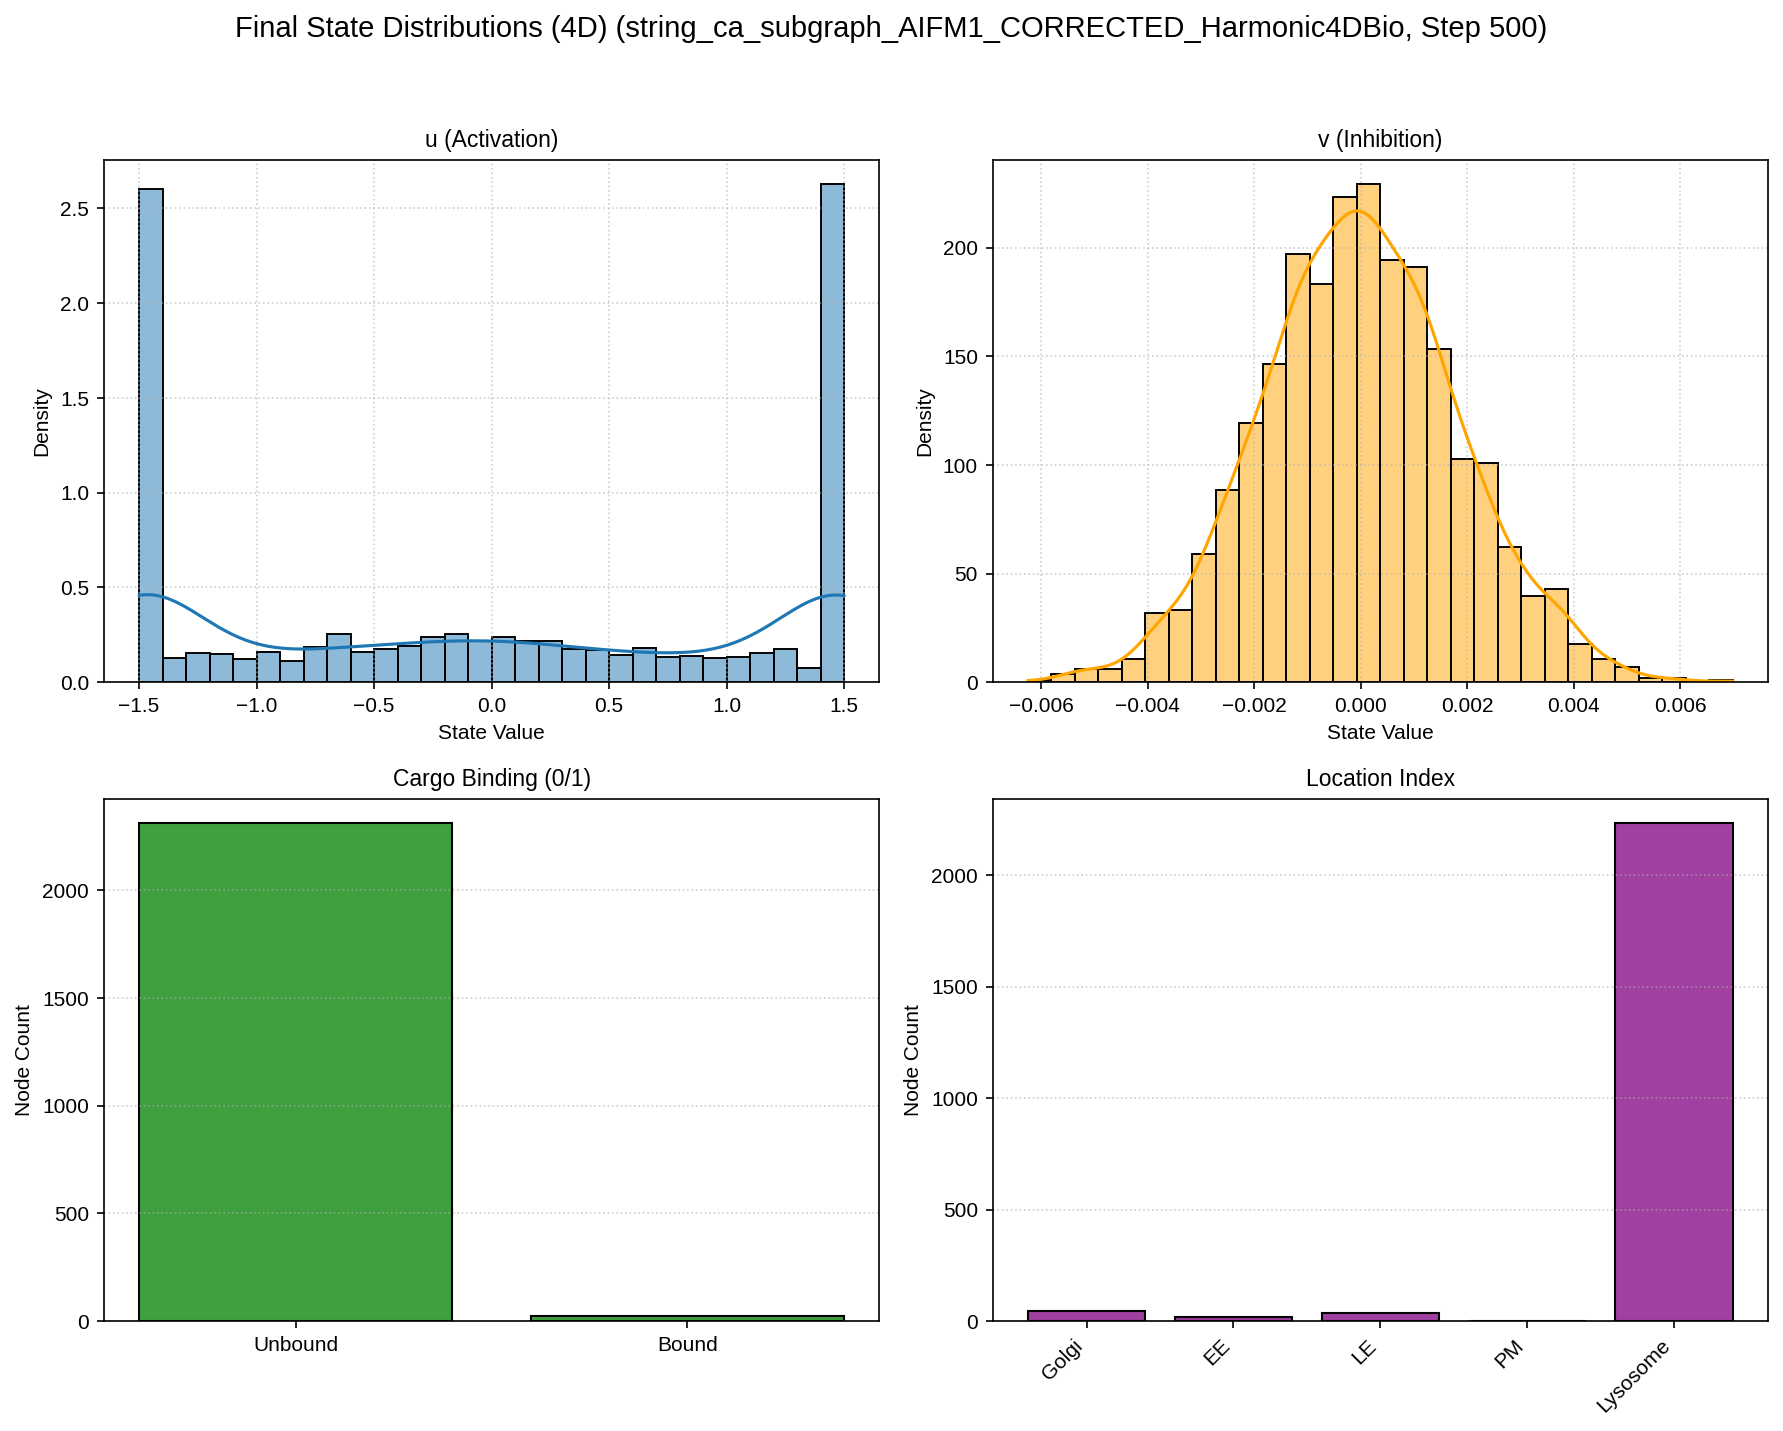


 ✅ Cell 3.2 execution complete.


In [7]:
# Cell 3.2: Calculate Basic Metrics and Plot Distributions (4D Biological Run)
# Description: Calculates basic metrics (variance, entropy, clustering) and generates
#              final state distribution plots for the 4D biological state.
#              Requires reformatted DataFrames and history list from Cell 3.1/Cell 2.
#              MODIFIED: Corrected plotting code using direct dataframe access and checks.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # For plotting distributions
import os
import warnings
import traceback

# Ensure necessary functions are defined in Cell 1.1
required_funcs_cell3_2 = ["calculate_entropy_timeseries", "calculate_clustering_metric"]
for func_name in required_funcs_cell3_2:
     if func_name not in globals() or not callable(globals()[func_name]):
         print(f"❌ Function '{func_name}' not found. Ensure Cell 1.1 was correctly inserted and run.")
         raise NameError(f"Required analysis function '{func_name}' not found. Insert and run Cell 1.1.")

print(f"\n--- Cell 3.2: Calculate Basic Metrics and Plot Distributions (4D Biological Run) ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# --- Prerequisites Check ---
metrics_dist_error = False

# Check if Cell 3 setup was successful
if 'analysis_setup_successful_4dbio' not in globals() or not analysis_setup_successful_4dbio:
    print("❌ Metrics/Distributions Error: Analysis setup in Cell 3 failed.")
    metrics_dist_error = True

# Check for required input history list from Cell 2 (for final state dict/clustering)
# This check is needed because clustering metric needs the final state dict
if not metrics_dist_error and ('run_state_history_4dbio' not in locals() or not isinstance(run_state_history_4dbio, list) or not run_state_history_4dbio):
    print("❌ Metrics/Distributions Error: 'run_state_history_4dbio' missing or invalid (Run Cell 2). Clustering skipped.")
    # Do not set metrics_dist_error = True, allow other metrics/plots

# Check for required input DataFrames from Cell 3.1 (for variance/entropy/plotting)
# Use flags to track if each DF is available
act_df_avail = ('global_act_history_df_4dbio' in globals() and not global_act_history_df_4dbio.empty)
inh_df_avail = ('global_inh_history_df_4dbio' in globals() and not global_inh_history_df_4dbio.empty)
cargo_df_avail = ('global_cargo_history_df_4dbio' in globals() and not global_cargo_history_df_4dbio.empty)
loc_df_avail = ('global_loc_history_df_4dbio' in globals() and not global_loc_history_df_4dbio.empty)

if not metrics_dist_error and not (act_df_avail or inh_df_avail or cargo_df_avail or loc_df_avail):
    print("❌ Metrics/Distributions Error: All required DataFrames (Act, Inh, Cargo, Loc) missing or empty (Run Cell 3.1). Cannot calculate metrics or plot distributions.")
    metrics_dist_error = True # Set fatal error if no dataframes at all

# Check for required graph data from Cell 3 setup/load (for clustering)
graph_analysis_avail = ('G_analysis' in globals() and isinstance(G_analysis, nx.Graph) and G_analysis.number_of_nodes() > 0)
node_list_analysis_avail = ('node_list_analysis' in globals() and node_list_analysis)

if not metrics_dist_error and (not graph_analysis_avail or not node_list_analysis_avail):
     print("⚠️ Metrics/Distributions Warning: Graph data missing (Run Cell 3). Clustering skipped.")
     # Allow other metrics/plots

# Check for required config from Cell 1 (for state dim, indices, thresholds, output dir)
if not metrics_dist_error and ('config_for_4d_bio_run' not in globals() or config_for_4d_bio_run is None):
     print("❌ Metrics/Distributions Error: 'config_for_4d_bio_run' missing (Run Cell 1).")
     metrics_dist_error = True
elif not metrics_dist_error:
     cfg = config_for_4d_bio_run
     if 'STATE_DIM' not in cfg or cfg['STATE_DIM'] != 4: print(f"❌ Metrics/Distributions Error: Config STATE_DIM is not 4 ({cfg.get('STATE_DIM')})."); metrics_dist_error = True
     indices = ['ACT_IDX', 'INH_IDX', 'CARGO_IDX', 'LOC_IDX']
     if not all(idx in cfg for idx in indices): print(f"❌ Metrics/Distributions Error: Config is missing state indices: {indices}."); metrics_dist_error = True
     loc_consts = ['LOC_GOLGI', 'LOC_EE', 'LOC_LE', 'LOC_PM', 'LOC_LY', 'NUM_LOCATIONS']
     if not all(const in cfg for const in loc_consts): print(f"⚠️ Metrics/Distributions Warning: Config missing location constants: {loc_consts}. Location plot may fail."); # Allow proceed

# Check for output directory from Cell 3 setup
if not metrics_dist_error and ('exp_output_dir_4dbio' not in globals() or not exp_output_dir_4dbio or not os.path.isdir(exp_output_dir_4dbio)):
     print("❌ Metrics/Distributions Error: Output directory 'exp_output_dir_4dbio' missing or invalid (Run Cell 3).")
     metrics_dist_error = True


# --- Initialize or update global metrics store ---
# Get metrics from run_experiment_no_analysis if available (Cell 2)
global_analysis_metrics_4dbio = globals().get('run_metrics_4dbio', {}).copy()
# Ensure it's a dictionary
if not isinstance(global_analysis_metrics_4dbio, dict):
     warnings.warn("⚠️ Global metrics store is not a dict, initializing empty.")
     global_analysis_metrics_4dbio = {}


# --- Execute Metrics Calculation and Distribution Plotting ---
if not metrics_dist_error:
    print("Calculating final state metrics (4D) and plotting distributions...")

    # Get final state dictionary from history list (from Cell 2) for clustering and distributions
    # This assumes run_state_history_4dbio is valid and not empty (checked above)
    final_states_dict = None
    if 'run_state_history_4dbio' in locals() and isinstance(run_state_history_4dbio, list) and run_state_history_4dbio:
        final_step_index = len(run_state_history_4dbio) - 1
        if final_step_index >= 0:
             final_states_dict = run_state_history_4dbio[final_step_index]
        else: # Should not happen if list not empty, but for safety
             print("⚠️ History list is non-empty but has no steps (only initial state?).")


    # Calculate Variance & Entropy (Act/Inh) using DataFrames from Cell 3.1
    print("\nCalculating final state variance & entropy (Act/Inh)...")

    # Use DataFrames from Cell 3.1 for variance/entropy
    if act_df_avail:
        final_activations_s = global_act_history_df_4dbio.iloc[-1].dropna()
        # Ensure variance/entropy are calculated/updated in the metrics dict
        var_act_calc = np.var(final_activations_s.values) if not final_activations_s.empty else np.nan
        if 'final_variance_activation' not in global_analysis_metrics_4dbio or pd.isna(global_analysis_metrics_4dbio['final_variance_activation']):
             global_analysis_metrics_4dbio['final_variance_activation'] = var_act_calc
        ent_func = globals().get('calculate_entropy_timeseries')
        if callable(ent_func):
             # Pass the pandas Series directly to the entropy function
             ent_act_calc = ent_func(final_activations_s) if not final_activations_s.empty else np.nan
             if 'final_entropy_activation' not in global_analysis_metrics_4dbio or pd.isna(global_analysis_metrics_4dbio['final_entropy_activation']):
                  global_analysis_metrics_4dbio['final_entropy_activation'] = ent_act_calc
        print(f"  Final Activation Variance: {global_analysis_metrics_4dbio.get('final_variance_activation', np.nan):.6f}")
        print(f"  Final Activation Entropy: {global_analysis_metrics_4dbio.get('final_entropy_activation', np.nan):.4f}")
    else: print("⚠️ Activation DataFrame not available for variance/entropy.")


    if inh_df_avail:
        final_inhibitions_s = global_inh_history_df_4dbio.iloc[-1].dropna()
        var_inh_calc = np.var(final_inhibitions_s.values) if not final_inhibitions_s.empty else np.nan
        if 'final_variance_inhibition' not in global_analysis_metrics_4dbio or pd.isna(global_analysis_metrics_4dbio['final_variance_inhibition']):
             global_analysis_metrics_4dbio['final_variance_inhibition'] = var_inh_calc
        ent_func = globals().get('calculate_entropy_timeseries')
        if callable(ent_func):
             # Pass the pandas Series directly to the entropy function
             ent_inh_calc = ent_func(final_inhibitions_s) if not final_inhibitions_s.empty else np.nan
             if 'final_entropy_inhibition' not in global_analysis_metrics_4dbio or pd.isna(global_analysis_metrics_4dbio['final_entropy_inhibition']):
                  global_analysis_metrics_4dbio['final_entropy_inhibition'] = ent_inh_calc

        print(f"  Final Inhibition Variance: {global_analysis_metrics_4dbio.get('final_variance_inhibition', np.nan):.6f}")
        print(f"  Final Inhibition Entropy: {global_analysis_metrics_4dbio.get('final_entropy_inhibition', np.nan):.4f}")
    else: print("⚠️ Inhibition DataFrame not available for variance/entropy.")


    # --- Calculate Clustering Metric (using full 4D state dict) ---
    print("\nCalculating final state clustering metric (4D)...")
    clust_func = globals().get('calculate_clustering_metric')
    if callable(clust_func) and graph_analysis_avail and final_states_dict:
        try:
            clustering_threshold_cfg = config_for_4d_bio_run.get('rule_params', {}).get('clustering_threshold', 0.2)
            # Pass the final state dictionary and graph to the clustering function
            final_clust = clust_func(G_analysis, final_states_dict, clustering_threshold_cfg);
            state_dim_local = config_for_4d_bio_run.get('STATE_DIM', 4) # Get state dim from config
            global_analysis_metrics_4dbio[f'final_clustering_fraction_{state_dim_local}d'] = final_clust
            print(f"  Final Clustering ({state_dim_local}D state): {final_clust:.4f}")
        except Exception as e_clust: print(f"  ❌ Error calculating clustering: {e_clust}"); traceback.print_exc(); global_analysis_metrics_4dbio[f"final_clustering_fraction_{state_dim_local}d"] = np.nan
    else:
        print("⚠️ Clustering calculation skipped (function missing or not callable, or graph/state data invalid).")


    # --- Plot Final State Distributions (All 4 Dims) ---
    print("\nGenerating final state distribution plots (4D)...")
    dist_plot_path = os.path.join(
        exp_output_dir_4dbio, "final_state_distributions_4D_Analysis.png"
    )
    fig_dist = None; plot_success_cell3_2_dist = False

    # Check if final_states_dict is available before attempting to plot
    if final_states_dict:
        try:
            fig_dist, axes_dist = plt.subplots(2, 2, figsize=(12, 10))
            axes_dist = axes_dist.flatten()

            # Convert final state dictionary to numpy array for plotting if needed
            # This might be redundant if DFs are available, but provides a fallback using the dict
            num_nodes_hist = len(node_list_analysis)
            state_dim_local = config_for_4d_bio_run.get('STATE_DIM', 4)
            final_states_array_plot = np.full((num_nodes_hist, state_dim_local), np.nan)
            default_state_vec_plot = np.array(config_for_4d_bio_run.get('DEFAULT_INACTIVE_STATE', [np.nan]*state_dim_local), dtype=float)

            for i, node_id in enumerate(node_list_analysis):
                state_vec = final_states_dict.get(node_id, default_state_vec_plot)
                if isinstance(state_vec, np.ndarray) and state_vec.shape == (state_dim_local,):
                    final_states_array_plot[i, :] = state_vec

            # Create pandas Series from the final array slice for plotting (allows dropna)
            final_activations_plot_s = pd.Series(final_states_array_plot[:, ACT_IDX], index=node_list_analysis).dropna()
            final_inhibitions_plot_s = pd.Series(final_states_array_plot[:, INH_IDX], index=node_list_analysis).dropna()
            final_cargo_plot_s = pd.Series(final_states_array_plot[:, CARGO_IDX], index=node_list_analysis).dropna()
            final_locations_plot_s = pd.Series(final_states_array_plot[:, LOC_IDX], index=node_list_analysis).dropna()


            title_step = final_step_index if final_step_index >= 0 else "N/A"
            title_suffix = f"({config_for_4d_bio_run.get('EXPERIMENT_NAME', 'Current Run')}, Step {title_step})"
            fig_dist.suptitle(f'Final State Distributions (4D) {title_suffix}', fontsize=14)
            plt.style.use('seaborn-v0_8-whitegrid')

            # Plot Activation (u)
            ax = axes_dist[ACT_IDX]
            if not final_activations_plot_s.empty:
                 sns.histplot(final_activations_plot_s, bins=30, kde=True, ax=ax, stat="density", edgecolor='black')
                 ax.set_xlabel('State Value')
                 ax.set_ylabel('Density')
            else:
                 ax.text(0.5, 0.5, "No Activation Data", ha='center', va='center', transform=ax.transAxes)
                 ax.set_xlabel('')
                 ax.set_ylabel('')
            ax.set_title(f'{config_for_4d_bio_run.get("dim_label_0", "u (Activation)")}', fontsize=11)
            ax.grid(True, linestyle=':', alpha=0.6)


            # Plot Inhibition (v)
            ax = axes_dist[INH_IDX]
            if not final_inhibitions_plot_s.empty:
                 sns.histplot(final_inhibitions_plot_s, bins=30, kde=True, ax=ax, stat="density", edgecolor='black', color='orange')
                 ax.set_xlabel('State Value')
                 ax.set_ylabel('Density')
            else:
                 ax.text(0.5, 0.5, "No Inhibition Data", ha='center', va='center', transform=ax.transAxes)
                 ax.set_xlabel('')
                 ax.set_ylabel('')
            ax.set_title(f'{config_for_4d_bio_run.get("dim_label_1", "v (Inhibition)")}', fontsize=11)
            ax.grid(True, linestyle=':', alpha=0.6)


            # Plot Cargo Binding (0/1)
            ax = axes_dist[CARGO_IDX]
            if not final_cargo_plot_s.empty:
                vals = final_cargo_plot_s.values[~np.isnan(final_cargo_plot_s.values)]
                if vals.size > 0:
                    sns.histplot(vals, bins=[-0.5, 0.5, 1.5], discrete=True, shrink=0.8, ax=ax, stat="count", color='green', edgecolor='black')
                    ax.set_xticks([0, 1])
                    ax.set_xticklabels(['Unbound', 'Bound'])
                    ax.set_xlabel('')
                    ax.set_ylabel('Node Count')
                else: # If vals is empty after dropna
                     ax.text(0.5, 0.5, "No Cargo Data", ha='center', va='center', transform=ax.transAxes)
                     ax.set_xlabel('')
                     ax.set_ylabel('')
            else: # If final_cargo_plot_s is empty
                ax.text(0.5, 0.5, "No Cargo Data", ha='center', va='center', transform=ax.transAxes)
                ax.set_xlabel('')
                ax.set_ylabel('')
            ax.set_title(f'{config_for_4d_bio_run.get("dim_label_2", "Cargo Binding (0/1)")}', fontsize=11)
            ax.grid(True, axis='y', linestyle=':', alpha=0.6)


            # Plot Location Index
            ax = axes_dist[LOC_IDX]
            if not final_locations_plot_s.empty:
                 loc_values = final_locations_plot_s.values[~np.isnan(final_locations_plot_s.values)]
                 if loc_values.size > 0:
                      location_map_local = {
                           config_for_4d_bio_run.get('LOC_GOLGI', 0): "Golgi", config_for_4d_bio_run.get('LOC_EE', 1): "EE", config_for_4d_bio_run.get('LOC_LE', 2): "LE",
                           config_for_4d_bio_run.get('LOC_PM', 3): "PM", config_for_4d_bio_run.get('LOC_LY', 4): "Lysosome", # Use full name for LY
                      }
                      # Ensure ticks only cover defined locations
                      tick_positions = sorted(location_map_local.keys())
                      tick_labels = [location_map_local.get(i, str(i)) for i in tick_positions]
                      num_locations_cfg = config_for_4d_bio_run.get('NUM_LOCATIONS', 5)
                      location_bins = np.arange(num_locations_cfg + 1) - 0.5 # Bins centered around integer indices
                      sns.histplot(loc_values, bins=location_bins, discrete=True, shrink=0.8, ax=ax, stat="count", color='purple', edgecolor='black')
                      ax.set_xticks(tick_positions)
                      ax.set_xticklabels(tick_labels, rotation=45, ha='right')
                      ax.set_xlabel('')
                      ax.set_ylabel('Node Count')
                      ax.set_title(f'{config_for_4d_bio_run.get("dim_label_3", "Location Index")}', fontsize=11)
                      ax.grid(True, axis='y', linestyle=':', alpha=0.6)
                 else: # If loc_values is empty after dropna
                      ax.text(0.5, 0.5, "No Location Data", ha='center', va='center', transform=ax.transAxes)
                      ax.set_xlabel('')
                      ax.set_ylabel('')
                      ax.set_title(f'{config_for_4d_bio_run.get("dim_label_3", "Location Index")}', fontsize=11)
                      ax.grid(True, axis='y', linestyle=':', alpha=0.6)
            else: # If final_locations_plot_s is empty
                 ax.text(0.5, 0.5, "No Location Data", ha='center', va='center', transform=ax.transAxes)
                 ax.set_xlabel('')
                 ax.set_ylabel('')
                 ax.set_title(f'{config_for_4d_bio_run.get("dim_label_3", "Location Index")}', fontsize=11)
                 ax.grid(True, axis='y', linestyle=':', alpha=0.6)


            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            fig_dist.savefig(dist_plot_path, dpi=150, bbox_inches='tight')
            plt.close(fig_dist)
            print(f"✅ Saved 4D final state distribution plot to: {dist_plot_path}")
            display(Image(filename=dist_plot_path))
            plot_success_cell3_2_dist = True # Flag plot success

        except Exception as e_step2_analysis:
            print(f"❌ Error during Step 2 analysis: {e_step2_analysis}")
            traceback.print_exc()
            metrics_dist_error = True # Flag error

    else: # if final_states_dict is None (meaning history was invalid/empty)
         print("⚠️ Final state dictionary is not available for metric calculation or distribution plotting.")
         metrics_dist_error = True


else: # metrics_dist_error was True from prereqs
    print("Basic metrics calculation and distribution plotting skipped due to missing prerequisites or errors.")

# Note: We do NOT store global_analysis_metrics_4dbio here as it's updated within the cell.
# The last updated version will persist after the cell runs.

print("\n ✅ Cell 3.2 execution complete.")

In [8]:
# Cell 3.21: Calculate Degree Baseline
# Description: Calculates the list of top nodes by degree for the loaded graph.
#              This serves as a static baseline for comparison in later analysis.
#              Requires graph data from Cell 3. Stores the result globally.

import networkx as nx
import os
import warnings
import time

print(f"\n--- Cell 3.21: Calculate Degree Baseline ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# --- Prerequisites Check ---
degree_calc_error = False

# Check if analysis setup in Cell 3 succeeded
if 'analysis_setup_successful_4dbio' not in globals() or not analysis_setup_successful_4dbio:
    print("❌ Degree Calculation Error: Analysis setup in Cell 3 failed.")
    degree_calc_error = True

# Check for required graph data from Cell 3 setup/load
if not degree_calc_error and ('G_analysis' not in globals() or not isinstance(G_analysis, nx.Graph) or G_analysis.number_of_nodes() == 0):
     print("❌ Degree Calculation Error: Graph G_analysis missing or invalid (Run Cell 3).")
     degree_calc_error = True
if not degree_calc_error and ('node_list_analysis' not in globals() or not isinstance(node_list_analysis, list) or not node_list_analysis):
     print("❌ Degree Calculation Error: Node list missing or invalid (Run Cell 3).")
     degree_calc_error = True

# Check for NODES_TO_PLOT_COUNT from config (Cell 1)
if not degree_calc_error and ('NODES_TO_PLOT_COUNT' not in globals() or not isinstance(NODES_TO_PLOT_COUNT, int)):
     print("⚠️ Degree Calculation Warning: NODES_TO_PLOT_COUNT missing or invalid. Using default 10 for top nodes list size.")
     # Allow to proceed, use a default size
     NODES_TO_PLOT_COUNT = 10


# --- Initialize global variable for this cell's output ---
global_baseline_nodes_degree = []

# --- Execute Degree Calculation ---
if not degree_calc_error:
    print("Calculating Degree baseline...")
    try:
        # Calculate degree for all nodes in the loaded graph
        degrees = dict(G_analysis.degree())

        # Filter degrees for nodes present in the simulation's node list (if different)
        # The node_list_analysis *should* be the list of nodes from G_analysis, but for safety
        degrees_filtered = {node: deg for node, deg in degrees.items() if node in node_list_analysis}

        if degrees_filtered:
            # Determine the number of top nodes to select
            n_baseline_degree = NODES_TO_PLOT_COUNT # Default size for this baseline list

            # Sort nodes by degree in descending order and select the top N
            global_baseline_nodes_degree = sorted(degrees_filtered, key=degrees_filtered.get, reverse=True)[:n_baseline_degree]

            print(f"  ✅ Baseline: Identified top {len(global_baseline_nodes_degree)} nodes by degree.")
        else:
            print("  ⚠️ Baseline (Degree): No degrees found for nodes present in simulation node_list.")
            # global_baseline_nodes_degree remains an empty list

    except Exception as e_deg:
        print(f"  ❌ Error calculating Degree baseline: {e_deg}")
        traceback.print_exc()
        degree_calc_error = True # Flag error

else: # degree_calc_error was True from prereqs
    print("Degree baseline calculation skipped due to missing prerequisites.")

# Note: Global variable global_baseline_nodes_degree is set whether successful (list of nodes) or failed (empty list)

print("\n ✅ Cell 3.21 execution complete.")


--- Cell 3.21: Calculate Degree Baseline (2025-04-28 21:11:46) ---
Calculating Degree baseline...
  ✅ Baseline: Identified top 10 nodes by degree.

 ✅ Cell 3.21 execution complete.



--- Cell 3.3: Plot Time Series (4D Biological Run) (2025-04-28 21:11:46.775717) ---
Generating 4D time series plot...
Plotting timeseries for nodes: ['9606.ENSP00000269305', '9606.ENSP00000244537', '9606.ENSP00000333277', '9606.ENSP00000352252', '9606.ENSP00000272317', '9606.ENSP00000254810', '9606.ENSP00000278572', '9606.ENSP00000300651', '9606.ENSP00000311032', '9606.ENSP00000358151']


✅ Saved 4D time series plot to: simulation_results/string_ca_subgraph_AIFM1_CORRECTED_Harmonic4DBio/timeseries_plot_4D_Analysis.png

Displaying generated plot:
simulation_results/string_ca_subgraph_AIFM1_CORRECTED_Harmonic4DBio/timeseries_plot_4D_Analysis.png


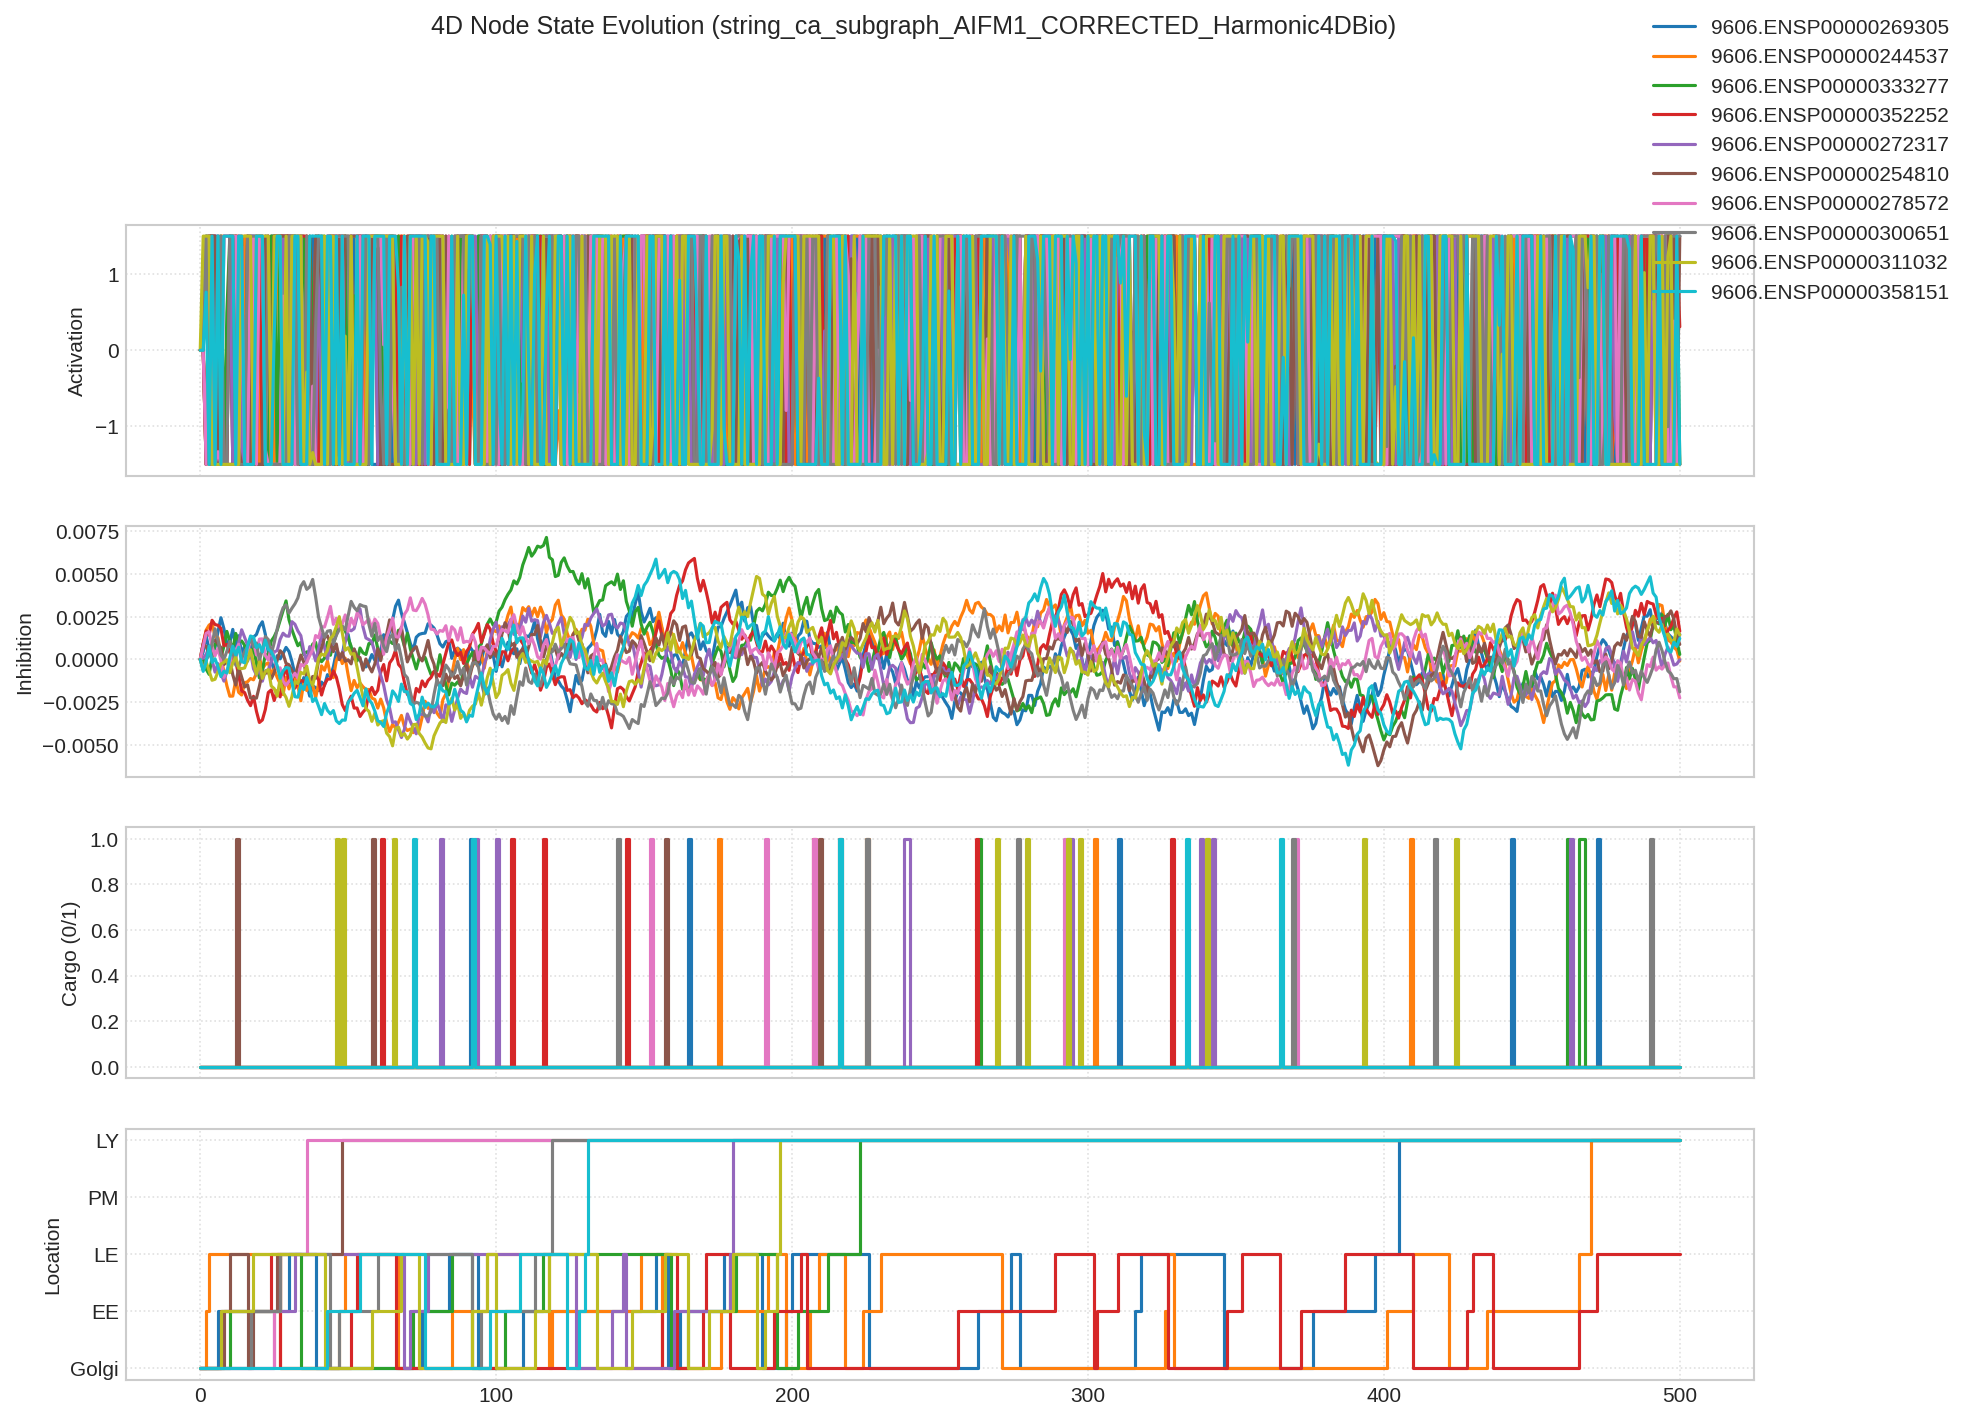


✅ Cell 3.3 execution complete.


In [9]:
# Cell 3.3: Plot Time Series (4D Biological Run)
# Description: Generates and displays the multi-panel time series plot for Activation,
#              Inhibition, Cargo, and Location for selected top nodes.
#              Requires DataFrames from Cell 3.1 and node mapping/degree list from Cell 3/3.05.

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import traceback
from IPython.display import display, Image  # For displaying saved images

# Ensure necessary function is defined in Cell 1.1
required_funcs_cell3_3 = ["plot_vector_node_history"]
for func_name in required_funcs_cell3_3:
    if func_name not in globals() or not callable(globals()[func_name]):
        raise NameError(f"Required analysis function '{func_name}' not found. Insert and run Cell 1.1.")

print(f"\n--- Cell 3.3: Plot Time Series (4D Biological Run) ({pd.Timestamp.now()}) ---")

# --- Prerequisites Check ---
ts_plot_error = False

if 'analysis_setup_successful_4dbio' not in globals() or not analysis_setup_successful_4dbio:
    print("❌ Time Series Plot Error: Analysis setup in Cell 3 failed.")
    ts_plot_error = True

# Check DataFrames
for df_name in ['global_act_history_df_4dbio',
                'global_inh_history_df_4dbio',
                'global_cargo_history_df_4dbio',
                'global_loc_history_df_4dbio']:
    if not ts_plot_error and (df_name not in globals() or globals()[df_name].empty):
        print(f"❌ Time Series Plot Error: {df_name} missing or empty (Run Cell 3.1).")
        ts_plot_error = True

# Check node list and mapping
if not ts_plot_error:
    if 'node_list_analysis' not in globals() or not isinstance(node_list_analysis, list) or not node_list_analysis:
        print("❌ Time Series Plot Error: Node list missing or invalid (Run Cell 3).")
        ts_plot_error = True
    if 'node_to_int_analysis' not in globals() or not isinstance(node_to_int_analysis, dict) or not node_to_int_analysis:
        print("❌ Time Series Plot Error: Node mapping missing or invalid (Run Cell 3).")
        ts_plot_error = True

# Check config
if not ts_plot_error:
    if 'config_for_4d_bio_run' not in globals() or config_for_4d_bio_run is None:
        print("❌ Time Series Plot Error: 'config_for_4d_bio_run' missing (Run Cell 1).")
        ts_plot_error = True
    else:
        cfg = config_for_4d_bio_run
        if 'NODES_TO_PLOT_COUNT' not in cfg:
            warnings.warn("NODES_TO_PLOT_COUNT missing; defaulting to 10.")
            cfg['NODES_TO_PLOT_COUNT'] = 10
        for idx in ['ACT_IDX', 'INH_IDX', 'CARGO_IDX', 'LOC_IDX']:
            if idx not in cfg:
                print(f"❌ Time Series Plot Error: Config missing {idx}.")
                ts_plot_error = True

# Fix for exp_output_dir_4dbio potentially being None
base_output = exp_output_dir_4dbio if isinstance(globals().get('exp_output_dir_4dbio', None), str) else ""
plot_filename_ts = os.path.join(base_output, "timeseries_plot_4D_Analysis.png")

plot_success_cell3_3 = False
fig_ts_4d = None

if not ts_plot_error:
    print("Generating 4D time series plot...")
    try:
        # Select nodes by degree baseline
        nodes_to_plot_ids = globals().get('global_baseline_nodes_degree', [])
        if not nodes_to_plot_ids:
            print("⚠️ No nodes selected for timeseries plot (baseline list empty).")
        else:
            print(f"Plotting timeseries for nodes: {nodes_to_plot_ids}")
            fig_ts_4d = plot_vector_node_history(
                global_act_history_df_4dbio,
                global_inh_history_df_4dbio,
                global_cargo_history_df_4dbio,
                global_loc_history_df_4dbio,
                nodes_to_plot_ids,
                node_to_int_analysis,
                f"4D Node State Evolution ({config_for_4d_bio_run.get('EXPERIMENT_NAME','Run')})"
            )
            if isinstance(fig_ts_4d, plt.Figure):
                fig_ts_4d.savefig(plot_filename_ts, dpi=150, bbox_inches='tight')
                print(f"✅ Saved 4D time series plot to: {plot_filename_ts}")
                plot_success_cell3_3 = True
            else:
                print("⚠️ Plotting function returned None or invalid figure.")
    except Exception as e:
        print(f"❌ Error during time series plotting: {e}")
        traceback.print_exc()
    finally:
        if fig_ts_4d is not None and plt.fignum_exists(fig_ts_4d.number):
            plt.close(fig_ts_4d)

if plot_success_cell3_3 and os.path.exists(plot_filename_ts):
    print(f"\nDisplaying generated plot:\n{plot_filename_ts}")
    display(Image(filename=plot_filename_ts))
elif not ts_plot_error:
    print("⚠️ Time series plot was not generated; nothing to display.")

print("\n✅ Cell 3.3 execution complete.")


In [10]:
# Cell 3.4: Generate Static Snapshots (4D Biological Run)
# Description: Generates static graph snapshots at specified steps using visualize_snapshot.
#              Node color = Act-Inh, Node size = Cargo status, Node shape = Location.
#              Requires history list from Cell 2 and graph data/pos from Cell 3.
#              MODIFIED: Fixed SyntaxError by correcting the indentation of the outer except block.
#              MODIFIED: Fixed TypeError by passing correct experiment name string and config dict to visualize_snapshot.
#              MODIFIED: Fixed NameError in finally block by checking the return value correctly.
#              MODIFIED: Ensure required config contains EXPERIMENT_NAME.

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
import warnings
from tqdm.auto import tqdm
import traceback
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from IPython.display import display, Image # For inline display

# Ensure necessary function is defined in Cell 1.1 (or 1.2 if override)
required_funcs_cell3_4 = ["visualize_snapshot"] # Check for the 4D plotting function
for func_name in required_funcs_cell3_4:
     if func_name not in globals() or not callable(globals()[func_name]):
         print(f"❌ Function '{func_name}' not found. Ensure Cell 1.1 (or 1.2) was correctly inserted and run.")
         raise NameError(f"Required analysis function '{func_name}' not found. Insert and run Cell 1.1 (or 1.2).")


print(f"\n--- Cell 3.4: Generate Static Snapshots (4D Biological Run) ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# --- Prerequisites Check ---
snapshot_error = False

# Check if analysis setup in Cell 3 succeeded
if 'analysis_setup_successful_4dbio' not in globals() or not analysis_setup_successful_4dbio:
    print("❌ Snapshot Error: Analysis setup in Cell 3 failed.")
    snapshot_error = True

# Check for required input history list from Cell 2
if not snapshot_error and ('run_state_history_4dbio' not in locals() or not isinstance(run_state_history_4dbio, list) or not run_state_history_4dbio):
    print("❌ Snapshot Error: 'run_state_history_4dbio' missing or invalid (Run Cell 2).")
    snapshot_error = True
elif not snapshot_error and not isinstance(run_state_history_4dbio[0], dict):
    print("❌ Snapshot Error: 'run_state_history_4dbio' entries are not dictionaries.")
    snapshot_error = True


# Check for required graph data/pos from Cell 3 setup/load
if not snapshot_error and ('G_analysis' not in globals() or not isinstance(G_analysis, nx.Graph) or G_analysis.number_of_nodes() == 0):
     print("❌ Snapshot Error: Graph G_analysis missing or invalid (Run Cell 3).")
     snapshot_error = True
if not snapshot_error and ('pos_analysis' not in globals() or not isinstance(pos_analysis, dict) or not pos_analysis):
     print("❌ Snapshot Error: Layout 'pos_analysis' missing or invalid (Run Cell 3).")
     snapshot_error = True


# Check for required config from Cell 1 (for exp name, steps, state indices/locs)
if not snapshot_error and ('config_for_4d_bio_run' not in globals() or config_for_4d_bio_run is None):
     print("❌ Snapshot Error: 'config_for_4d_bio_run' missing (Run Cell 1).")
     snapshot_error = True
elif not snapshot_error:
     cfg = config_for_4d_bio_run
     if 'SNAPSHOT_STEPS' not in cfg or not isinstance(cfg['SNAPSHOT_STEPS'], list):
          print("⚠️ Snapshot Warning: SNAPSHOT_STEPS missing or invalid in config. Using default steps.")
          # Default steps based on history length will be calculated if missing
     indices = ['ACT_IDX', 'INH_IDX', 'CARGO_IDX', 'LOC_IDX']
     if not all(idx in cfg for idx in indices):
          print(f"❌ Snapshot Error: Config is missing state indices for visualization: {indices}.")
          snapshot_error = True
     loc_consts = ['LOC_GOLGI', 'LOC_EE', 'LOC_LE', 'LOC_PM', 'LOC_LY', 'NUM_LOCATIONS']
     if not all(const in cfg for const in loc_consts):
          print(f"⚠️ Snapshot Warning: Config missing location constants: {loc_consts}. Snapshot legend may be incomplete.")
     if 'TARGET_NODE_ID' not in cfg: # Check target node ID is in config for visualizer
          print(f"⚠️ Snapshot Warning: Target Node ID missing from config for visualizer.")
     if 'EXPERIMENT_NAME' not in cfg: # Check experiment name is in config
          print(f"❌ Snapshot Error: EXPERIMENT_NAME missing from config.")
          snapshot_error = True


# Check for output directory from Cell 3 setup
if not snapshot_error and ('exp_output_dir_4dbio' not in globals() or not exp_output_dir_4dbio or not os.path.isdir(exp_output_dir_4dbio)):
     print("❌ Snapshot Error: Output directory 'exp_output_dir_4dbio' missing or invalid (Run Cell 3).")
     snapshot_error = True


# --- Execute Snapshot Generation ---
if not snapshot_error:
    snapshot_dir = os.path.join(exp_output_dir_4dbio, "snapshots_4d_analysis") # Use analysis suffix
    os.makedirs(snapshot_dir, exist_ok=True)
    steps_run = len(run_state_history_4dbio) - 1 # Total steps in history (0-indexed)

    # Get snapshot steps from config, calculate default if missing
    snapshot_steps = config_for_4d_bio_run.get('SNAPSHOT_STEPS')
    if snapshot_steps is None or not isinstance(snapshot_steps, list):
         print(f"Using default snapshot steps based on history length ({steps_run+1} steps total).")
         num_snaps = 5
         snapshot_steps = [int(i * (steps_run) / (num_snaps - 1)) for i in range(num_snaps)] if num_snaps > 1 and steps_run >= 0 else [steps_run if steps_run >= 0 else 0]
         if steps_run >= 0 and 0 not in snapshot_steps: snapshot_steps.insert(0, 0) # Ensure step 0 included if steps > 0
         snapshot_steps = sorted(list(set(snapshot_steps)))


    actual_snapshot_steps = sorted([s for s in snapshot_steps if isinstance(s, int) and 0 <= s <= steps_run])

    if not actual_snapshot_steps:
         print("   No valid snapshot steps to generate within the history range.")
    else:
        print(f"Generating 4D snapshots for steps: {actual_snapshot_steps} (History length: {steps_run+1}) -> {snapshot_dir}")
        snapshot_paths = {} # Store paths
        # Use tqdm only if many steps
        snap_iterator = tqdm(actual_snapshot_steps, desc="Generating 4D Bio Snapshots", leave=False, unit="snapshot") if len(actual_snapshot_steps) > 5 else actual_snapshot_steps

        # --- Start Outer Try Block ---
        try:
            for step_num in snap_iterator:
                 fig_snap_init = None; ax_snap = None; snap_fig_result = None;

                 # --- Start Inner Try Block ---
                 try:
                      # Create a new figure for each snapshot
                      fig_snap_init, ax_snap = plt.subplots(figsize=(12, 9))

                      # Ensure the step_num is valid for the history list
                      if step_num >= len(run_state_history_4dbio):
                           warnings.warn(f"⚠️ Snapshot step {step_num} is out of bounds for history ({len(run_state_history_4dbio)} steps). Skipping.")
                           # Close the figure created for this step
                           if fig_snap_init is not None and plt.fignum_exists(fig_snap_init.number): plt.close(fig_snap_init)
                           continue # Skip to next step

                      state_dict_to_vis = run_state_history_4dbio[step_num] # Use state dict from local history

                      # Call 4D visualizer function (should now have 'config' parameter)
                      snapshot_func = globals().get('visualize_snapshot') # Get function handle
                      if callable(snapshot_func):
                           # --- MODIFIED: Pass the full config dictionary as the 'config' parameter ---
                           # The visualizer function is now expected to accept 'config' and use its contents
                           snap_fig_result = snapshot_func(
                               G_analysis, # Pass loaded graph
                               state_dict_to_vis, # Pass state dict
                               pos_analysis, # Pass loaded pos
                               step_num, # Pass step number
                               config_for_4d_bio_run.get('EXPERIMENT_NAME', 'Current Run'), # Pass string experiment name
                               config=config_for_4d_bio_run, # Pass the full config dictionary
                               ax=ax_snap, verbose=False, add_colorbar=True, add_legend=True
                           )
                           # --- END MODIFIED ---


                           if snap_fig_result is not None and isinstance(snap_fig_result, plt.Figure):
                                snapshot_filename = f"snapshot_4d_bio_step_{step_num:0{len(str(steps_run))}d}_analysis.png" # Specific filename
                                snapshot_path = os.path.join(snapshot_dir, snapshot_filename)
                                snap_fig_result.savefig(snapshot_path, dpi=150, bbox_inches='tight')
                                snapshot_paths[step_num] = snapshot_path
                                # Do NOT assign to 'snap_fig' here, check snap_fig_result in finally

                           else: print(f"   ⚠️ 4D Visualization function failed for step {step_num} (returned None or invalid object).")
                      else:
                           # This case should be caught by the prerequisite check, but for safety
                           print("❌ visualize_snapshot function not found or not callable.")
                           # Close the figure created for this step
                           if fig_snap_init is not None and plt.fignum_exists(fig_snap_init.number): plt.close(fig_snap_init)
                           break # Stop if visualize_snapshot is fundamentally missing


                 except Exception as e_snap:
                      print(f"   ❌ Failed 4D snapshot step {step_num}: {e_snap}")
                      traceback.print_exc(limit=1)
                 finally:
                      # Ensure the figure created *by visualize_snapshot* is closed if it was successfully returned
                      if snap_fig_result is not None and isinstance(snap_fig_result, plt.Figure) and plt.fignum_exists(snap_fig_result.number):
                           plt.close(snap_fig_result)
                      # If visualize_snapshot itself failed to return a Figure, the initial figure might still be open
                      elif 'fig_snap_init' in locals() and fig_snap_init is not None and plt.fignum_exists(fig_snap_init.number):
                           plt.close(fig_snap_init)
                 # --- End Inner Try Block ---


            if actual_snapshot_steps: # Only print success message if at least one step was attempted
                 print(f"\n✅ Static 4D Snapshot generation attempt complete. Saved to: {snapshot_dir}")
            # else: message already printed if no actual_snapshot_steps

        except Exception as e:
            print(f"❌ Error during snapshot generation setup: {e}")
            traceback.print_exc()
        # --- End Outer Try Block ---
        # No need to set analysis_exec_error_4dbio = True here, as subsequent cells don't depend on this cell's success

else: # snapshot_error was True from prereqs
    print("Static 4D Snapshot generation skipped due to missing prerequisites.")

print("\n ✅ Cell 3.4 execution complete.")


--- Cell 3.4: Generate Static Snapshots (4D Biological Run) (2025-04-28 21:11:47) ---
Generating 4D snapshots for steps: [0, 124, 249, 374, 499] (History length: 501) -> simulation_results/string_ca_subgraph_AIFM1_CORRECTED_Harmonic4DBio/snapshots_4d_analysis

✅ Static 4D Snapshot generation attempt complete. Saved to: simulation_results/string_ca_subgraph_AIFM1_CORRECTED_Harmonic4DBio/snapshots_4d_analysis

 ✅ Cell 3.4 execution complete.
